### Mount Drive and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchsummary import summary
from skimage.util import random_noise
from torch.utils.data import Dataset

np.random.seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Required dependencies
!pip install autograd numpy scipy cvxopt scikit-learn matplotlib torch torchvision

In [ ]:
# Connect MFTMA folder to system
import sys
sys.path.append('/MFTMA_Analysis')

# Import mftma and pymanopt==0.2.4
import mftma
import pymanopt # ==0.2.4

from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze

### Load CIFAR10 Dataset

In [ ]:
# Dataset Preparation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

full_train = datasets.CIFAR10('../data', train=True, download=True,
                   transform=transform_train)

val_size = int(0.1 * len(full_train))                                             # 10% validation
train_size = len(full_train) - val_size

# Train, Test and Val dataset
train_dataset, val_dataset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

test_dataset = datasets.CIFAR10('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.ToTensor()
                   ]))

# Datasets for each Gaussian Noise level
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean,
                                                                      self.std)

gn_datasets = []
gaussian_noises = [0.0001, 0.0005, 0.001, 0.005,
                   0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00] # Gaussian noise levels

gn_datasets.append(test_dataset) # append original dataset

for sd in gaussian_noises:
  gn_datasets.append(datasets.CIFAR10('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.ToTensor(),
                       AddGaussianNoise(0., sd),
                   ])))


# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1024, shuffle=False)


# Data loaders for Gaussain noise levels
data_loaders = []
for dataset in gn_datasets:
  data_loaders.append(torch.utils.data.DataLoader(dataset,
                                          batch_size=len(dataset),
                                                  shuffle=False))

# Summary
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'\nNumber of datasets: {len(gn_datasets)}')
print(f'Gaussian noise levels: {gaussian_noises}')

Train dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000

Number of datasets: 12
Gaussian noise levels: [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]


### Load ResNet18 trained model

In [ ]:
# Model evaluation using Testing dataset
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1, reduction='sum')

def model_evaluation(model, device, test_loader, epoch):                          # Obtain testing accuracies of the trained model
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            running_loss += test_loss.item()
            total += target.size(0)

    avg_loss = running_loss / total
    accuracy = 100. * correct / total

    #print('\nTest set epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    epoch, avg_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    return avg_loss, accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 model
model = models.resnet18(weights=None)

model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = torch.nn.Identity()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(num_ftrs, 10)
)

# Load the saved state dictionary into the model
model_path = '/Model/ResNet_model_weights_with_Adam.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

### Check testing accuracy for each dataset with gaussian noise levels

In [ ]:
gaussian_noises.insert(0, 0) # for original dataset
for i, data_loader in enumerate(data_loaders):
  test_loss, test_acc = model_evaluation(model, device, data_loader, epoch=1)
  print(f'\nAccuracy of the loaded model on a dataset with Gaussian Noise of {gaussian_noises[i]} : {test_acc:.2f}%')


Accuracy of the loaded model on a dataset with Gaussian Noise of 0 : 93.86%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.0001 : 93.72%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.0005 : 93.80%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.001 : 93.78%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.005 : 93.61%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.01 : 93.62%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.05 : 69.60%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.1 : 28.93%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.25 : 12.75%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.5 : 10.24%

Accuracy of the loaded model on a dataset with Gaussian Noise of 0.75 : 10.02%

Accuracy of the loaded model on a dataset with Gaussian Noise of 1.0 : 10.04%


### Visualize images and predicted labels

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 9, Actual: 1
Predicted: 6, Actual: 1
Predicted: 6, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


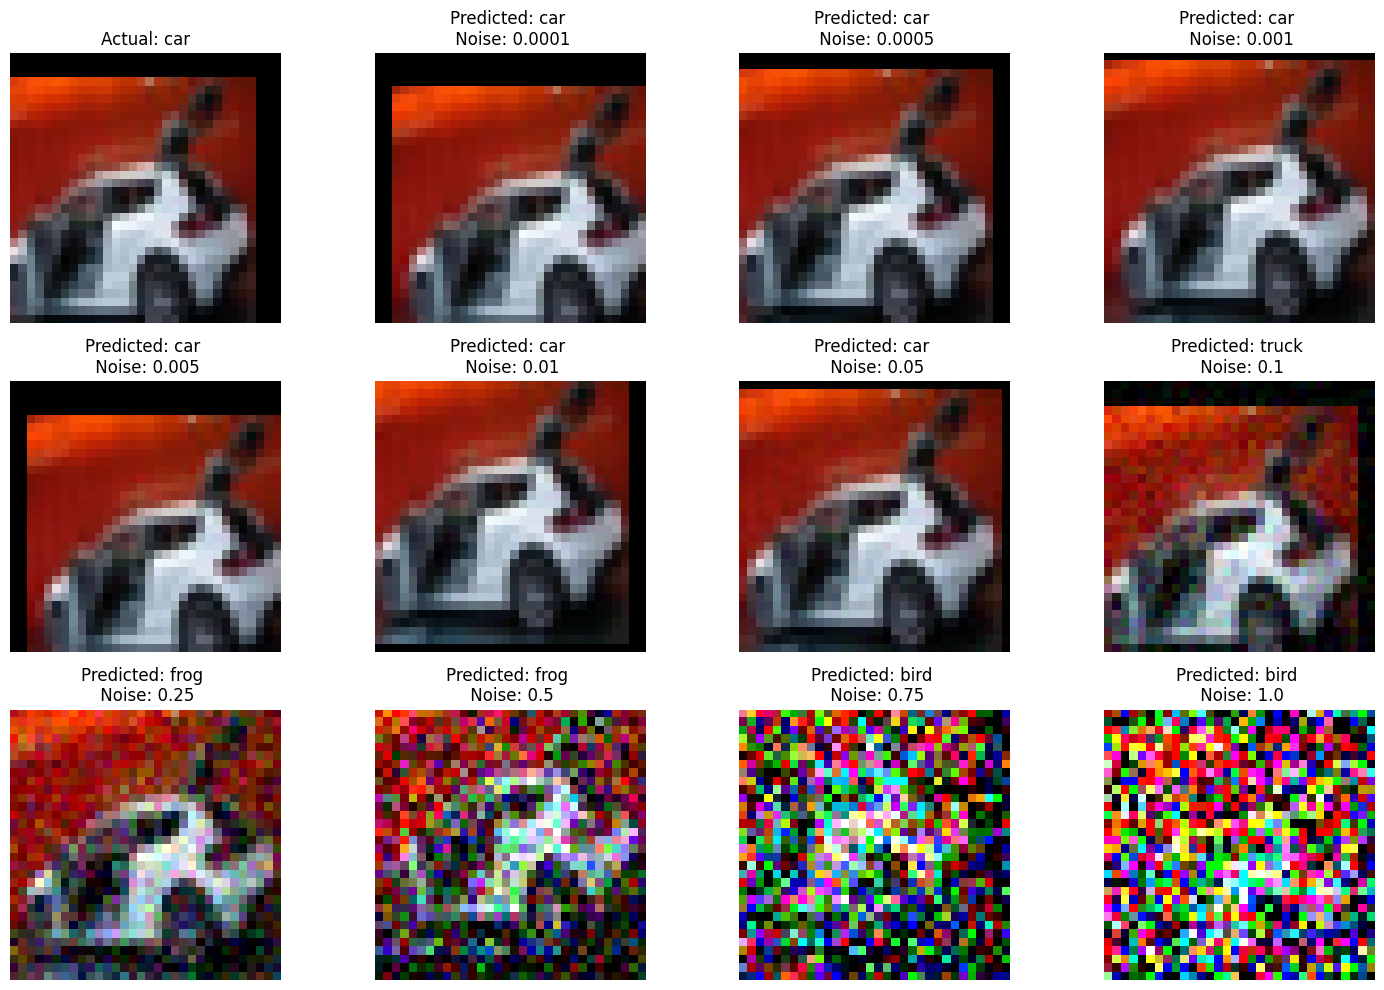

In [ ]:
# Select first 10 images' indexes where model gives correct predictions for test_loader
img_indexes = []
cp_images, cp_labels = next(iter(test_loader))  #  correct images and labels of first batch
for i, img in enumerate(cp_images):
  img = img.to(device).unsqueeze(0)
  label = cp_labels[i].to(device)
  output = model(img)
  _, predicted = torch.max(output, 1)
  if predicted == label:
    img_indexes.append(i)
    if len(img_indexes) == 10:
      break

# Get prediction for the first image of each data loader
images = []
correct_labels = []
predicted_labels = []

# Select random image from img_indexes
import random
img_index = img_indexes[random.randint(0,len(img_indexes)-1)]

for data_loader in data_loaders:
  images_batch, labels_batch = next(iter(data_loader))
  image = images_batch[img_index]
  label = labels_batch[img_index]
  image = image.to(device).unsqueeze(0)
  label = label.to(device)
  output = model(image)
  _, predicted = torch.max(output, 1)
  images.append(image.squeeze(0).cpu())
  correct_labels.append(label.cpu())
  predicted_labels.append(predicted.cpu())
  print(f'Predicted: {predicted.item()}, Actual: {label.item()}')

# classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Visuallize images, actual label, predicted label, and Gaussian noise lavel
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
  if i == 0:
    ax.imshow(cp_images[img_index].permute(1, 2, 0))
    ax.set_title(f'Actual: {classes[cp_labels[img_index].item()]}')
  else:
    ax.imshow(images[i-1].permute(1, 2, 0))
    ax.set_title(f'Predicted: {classes[predicted_labels[i-1].item()]} \n Noise: {gaussian_noises[i]}')
  ax.axis('off')
plt.tight_layout()
plt.show()

### Manifold analysis with perturbed input images

---------------------------------------------------------- 
For Gaussian Noise level: 0 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0 : 94.03%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.076935, radius 1.541324, dimension 18.447617, correlation 0.341622
layer_1_Conv2d capacity: 0.076426, radius 1.486230, dimension 18.772170, correlation 0.310469
layer_5_Conv2d capacity: 0.073647, radius 1.4450

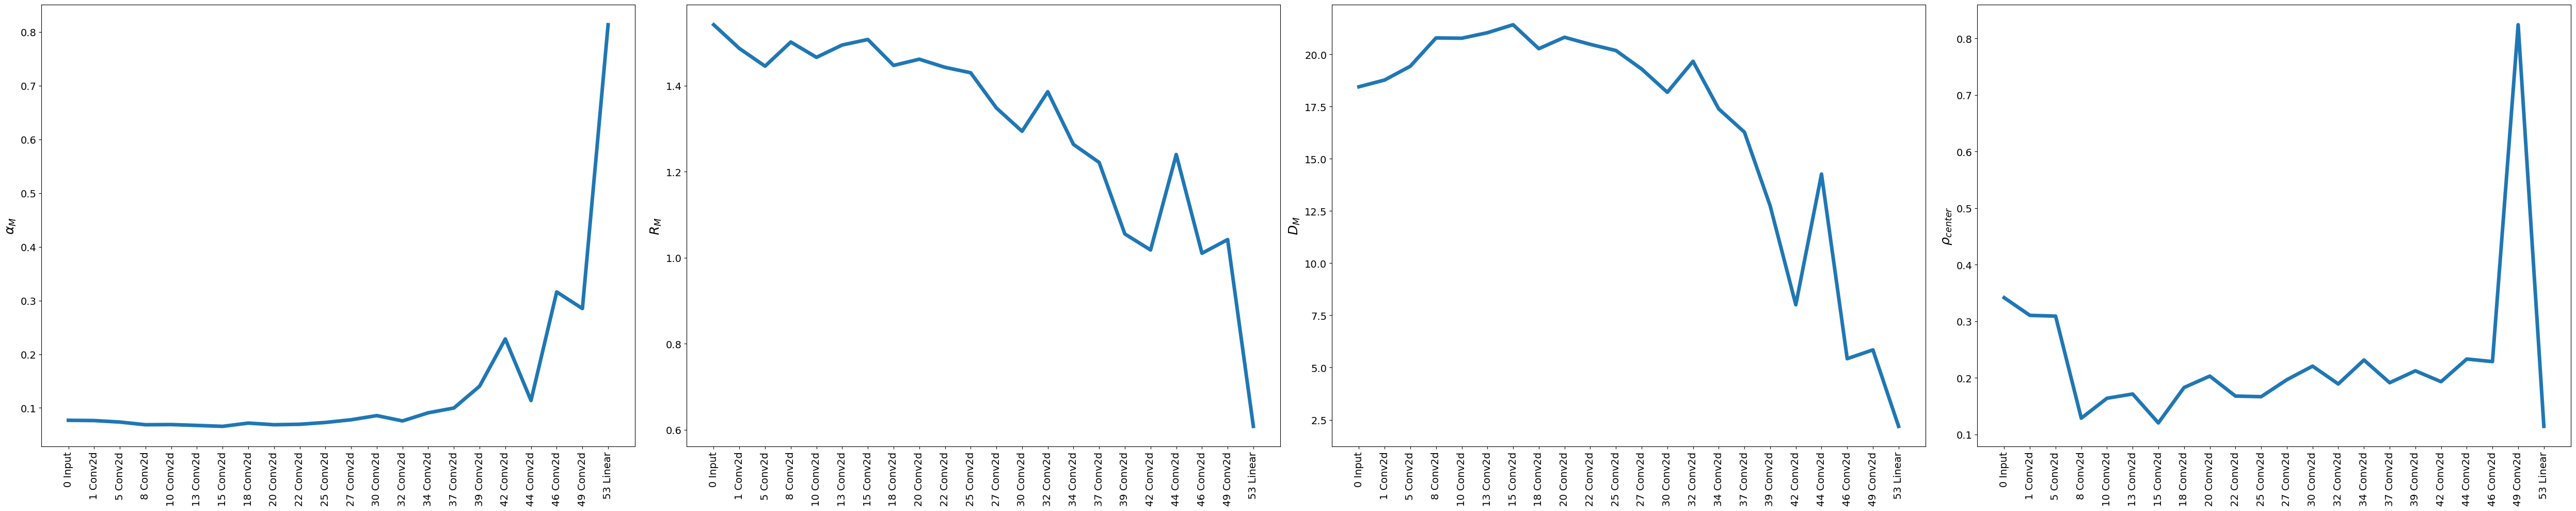

---------------------------------------------------------- 
For Gaussian Noise level: 0.0001 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.0001 : 93.68%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.076061, radius 1.545211, dimension 18.641389, correlation 0.321929
layer_1_Conv2d capacity: 0.080852, radius 1.433155, dimension 18.041675, correlation 0.302068
layer_5_Conv2d capacity: 0.074590, rad

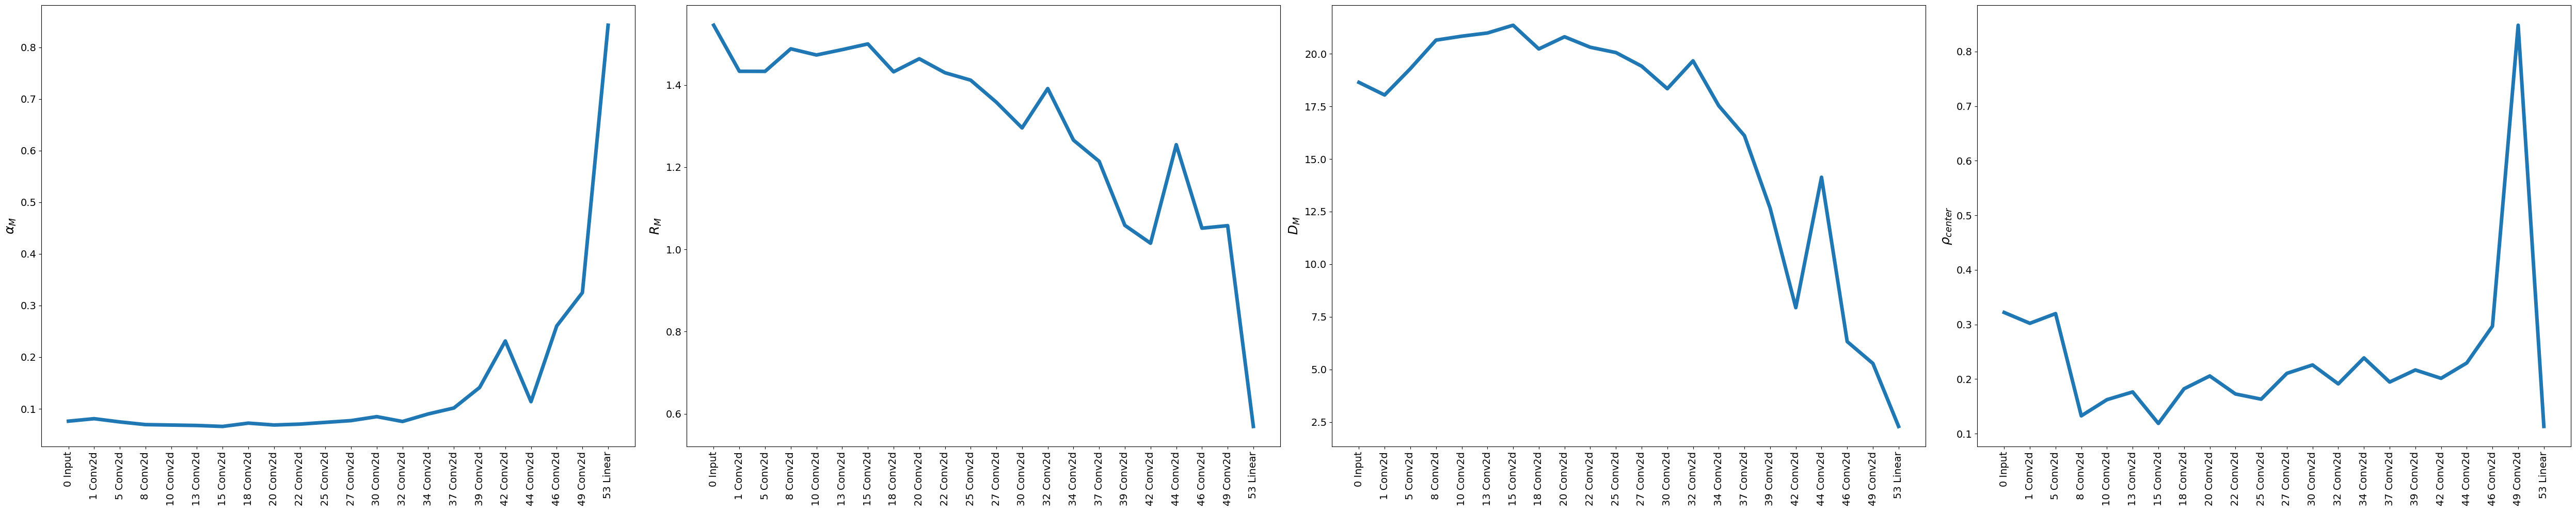

---------------------------------------------------------- 
For Gaussian Noise level: 0.0005 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.0005 : 93.86%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.087855, radius 1.446387, dimension 16.768199, correlation 0.321199
layer_1_Conv2d capacity: 0.069022, radius 1.589655, dimension 19.988492, correlation 0.301593
layer_5_Conv2d capacity: 0.075107, rad

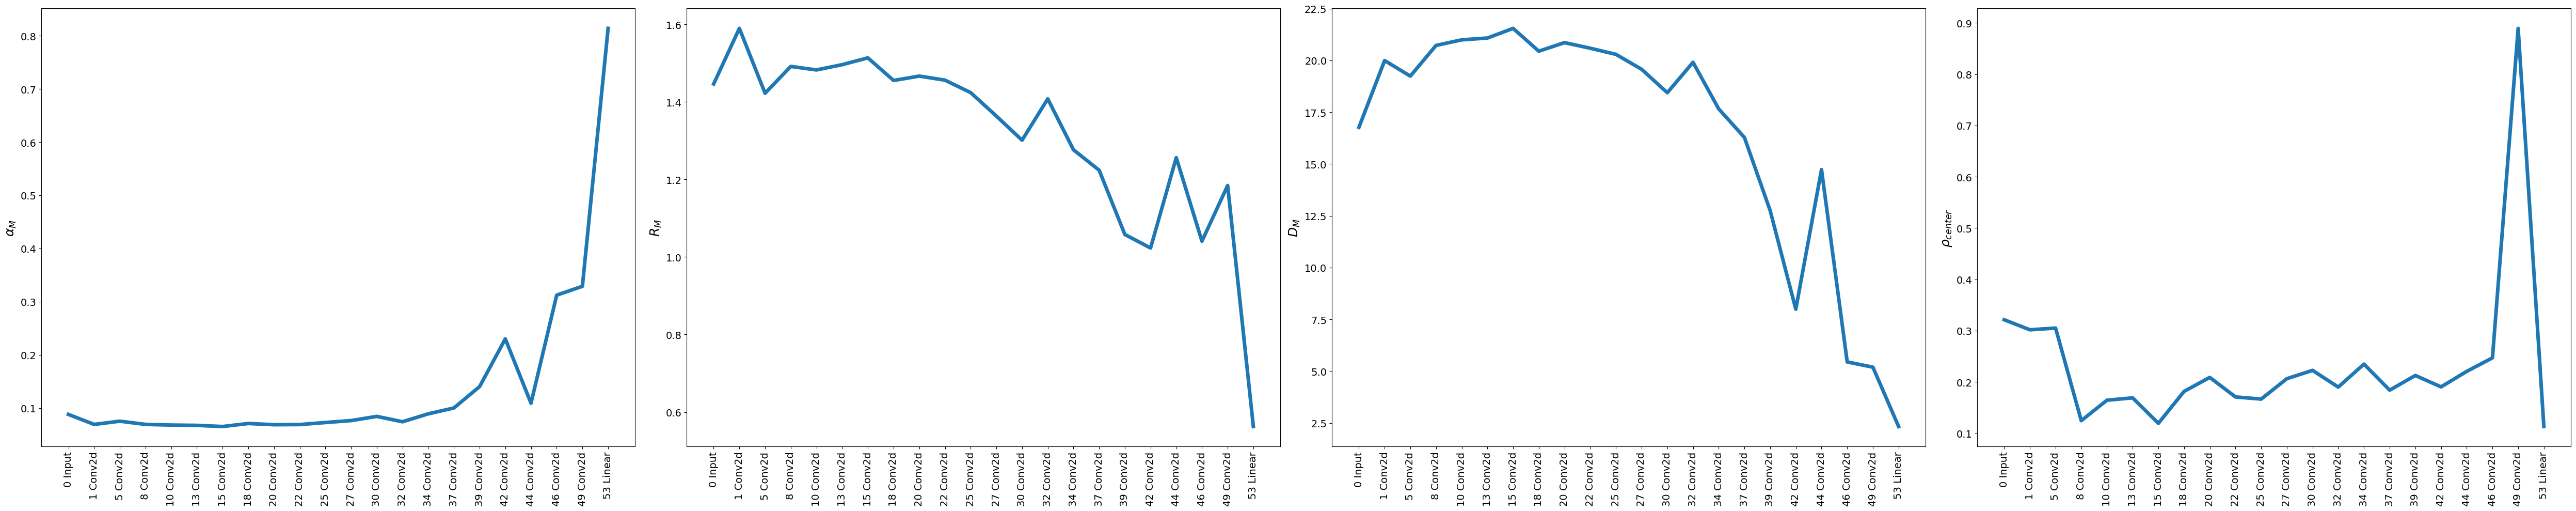

---------------------------------------------------------- 
For Gaussian Noise level: 0.001 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.001 : 93.85%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.076654, radius 1.533700, dimension 18.555356, correlation 0.332342
layer_1_Conv2d capacity: 0.080313, radius 1.434938, dimension 18.202262, correlation 0.311483
layer_5_Conv2d capacity: 0.075782, radiu

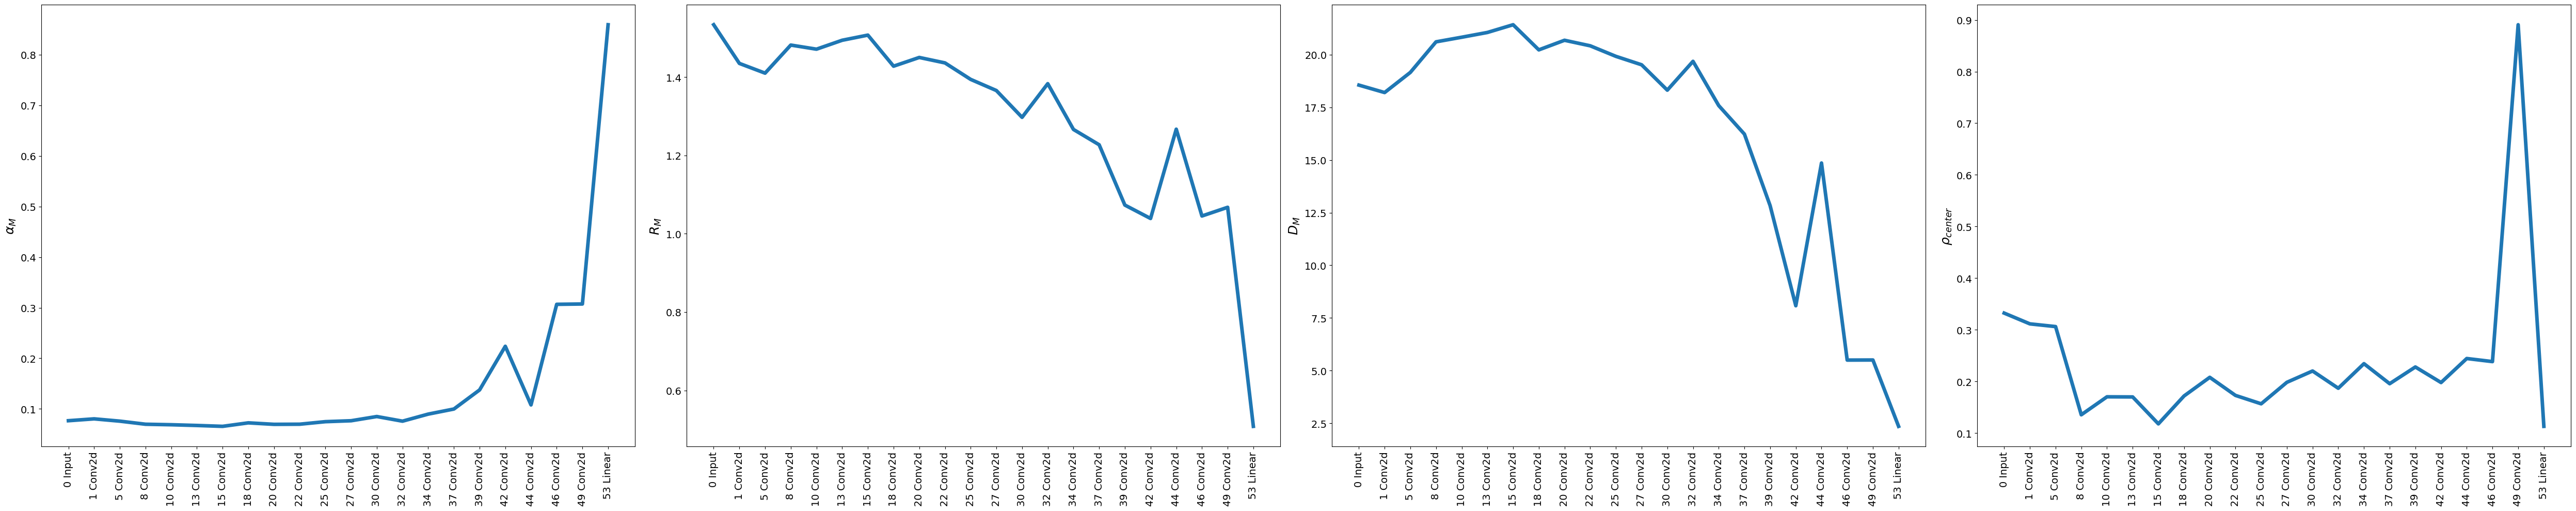

---------------------------------------------------------- 
For Gaussian Noise level: 0.005 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.005 : 93.66%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.075155, radius 1.586042, dimension 18.635561, correlation 0.308451
layer_1_Conv2d capacity: 0.078124, radius 1.455726, dimension 18.522531, correlation 0.273678
layer_5_Conv2d capacity: 0.075638, radiu

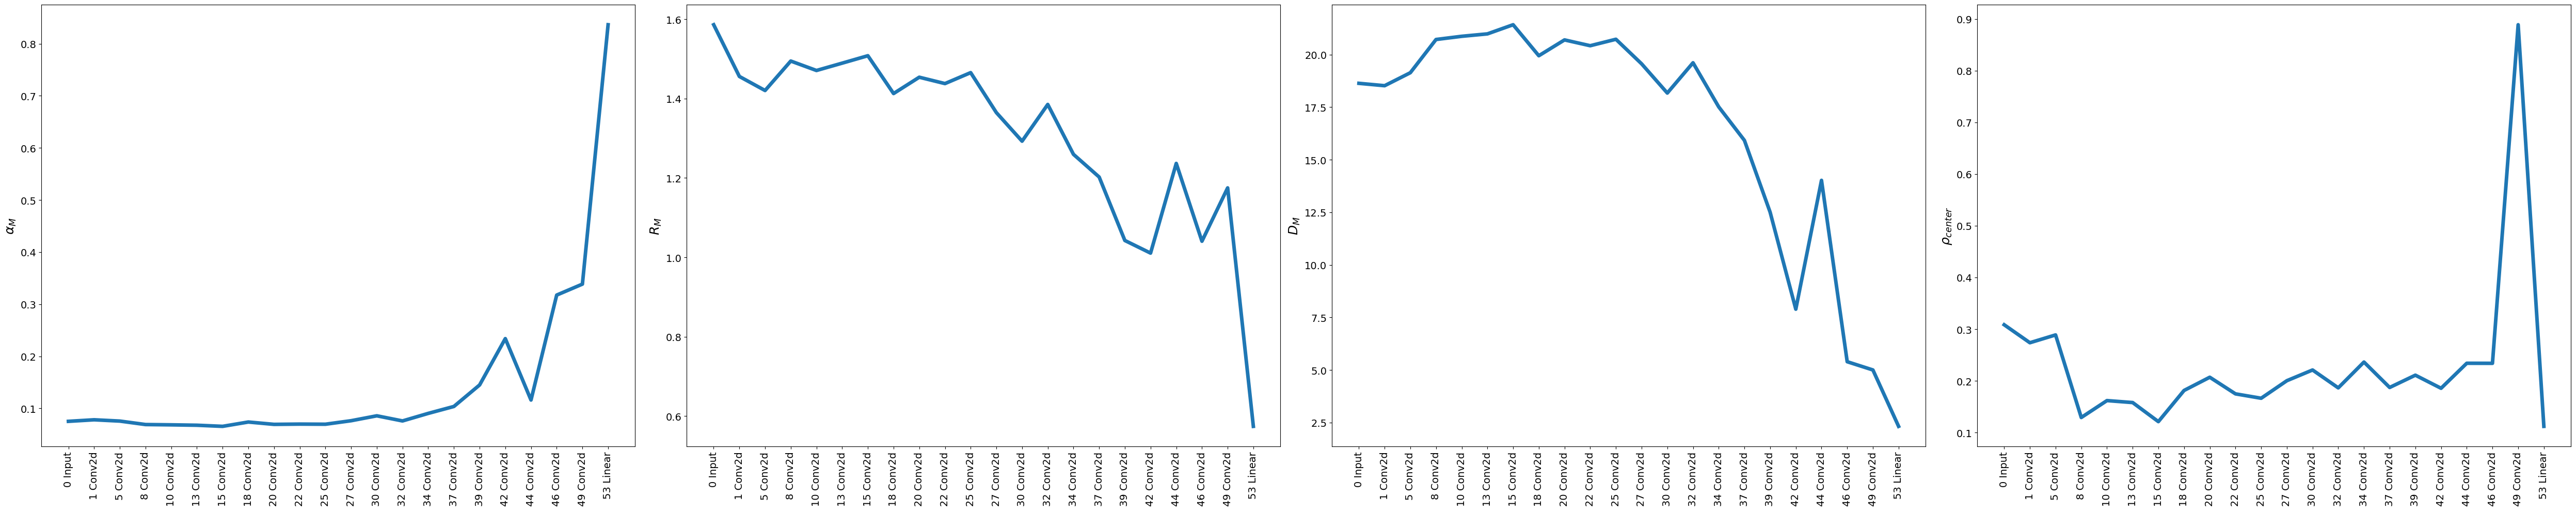

---------------------------------------------------------- 
For Gaussian Noise level: 0.01 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.01 : 93.62%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.073616, radius 1.567953, dimension 19.118025, correlation 0.404635
layer_1_Conv2d capacity: 0.075115, radius 1.494470, dimension 18.977292, correlation 0.348234
layer_5_Conv2d capacity: 0.072166, radius 

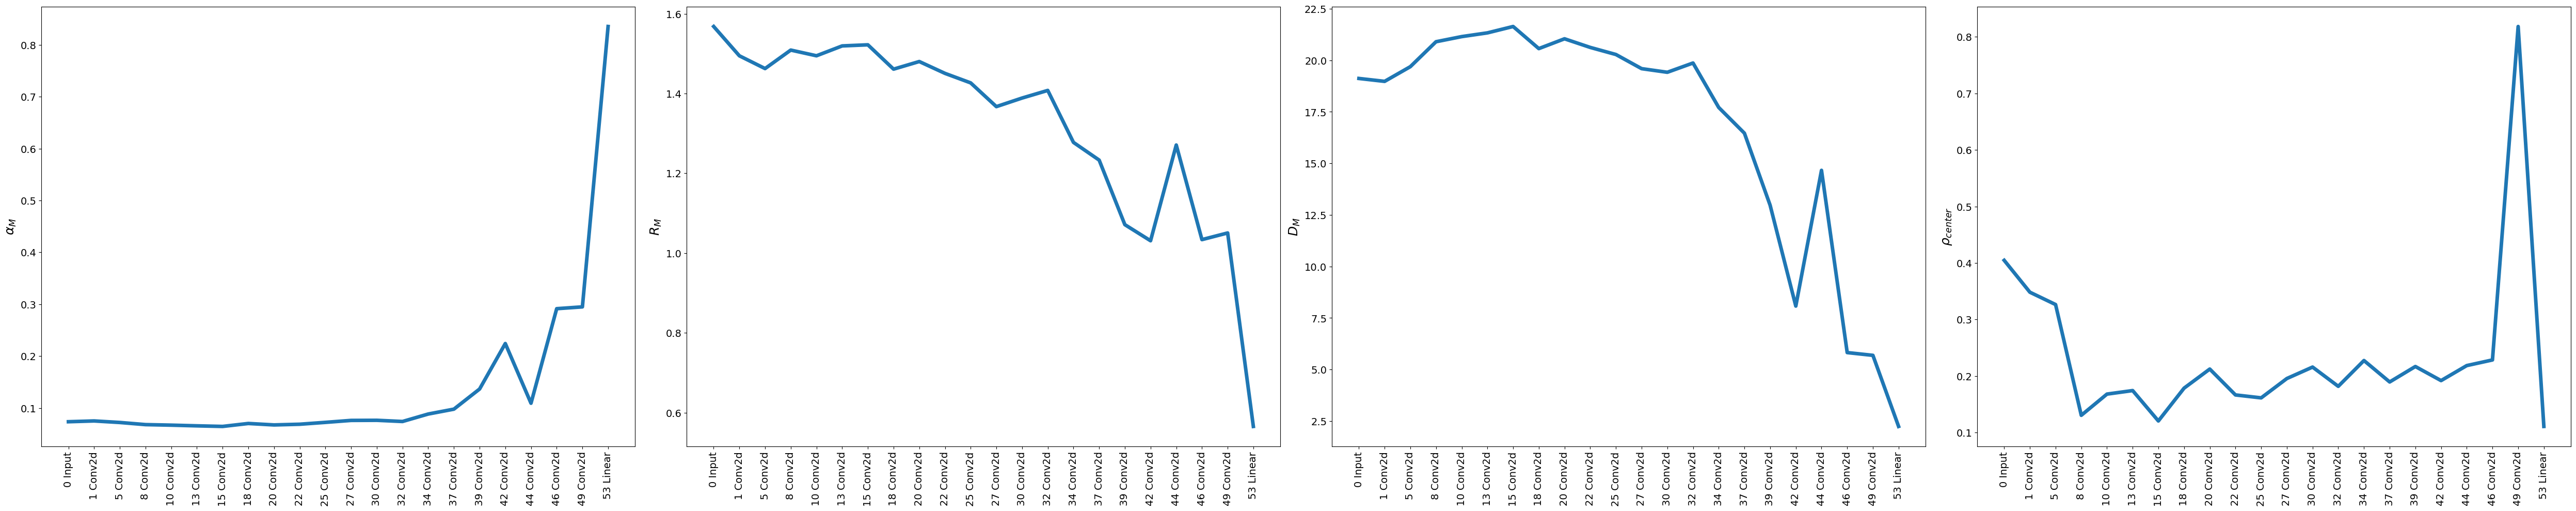

---------------------------------------------------------- 
For Gaussian Noise level: 0.05 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.05 : 69.77%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.069518, radius 1.627655, dimension 19.889387, correlation 0.342197
layer_1_Conv2d capacity: 0.069093, radius 1.557954, dimension 20.113548, correlation 0.318787
layer_5_Conv2d capacity: 0.070847, radius 

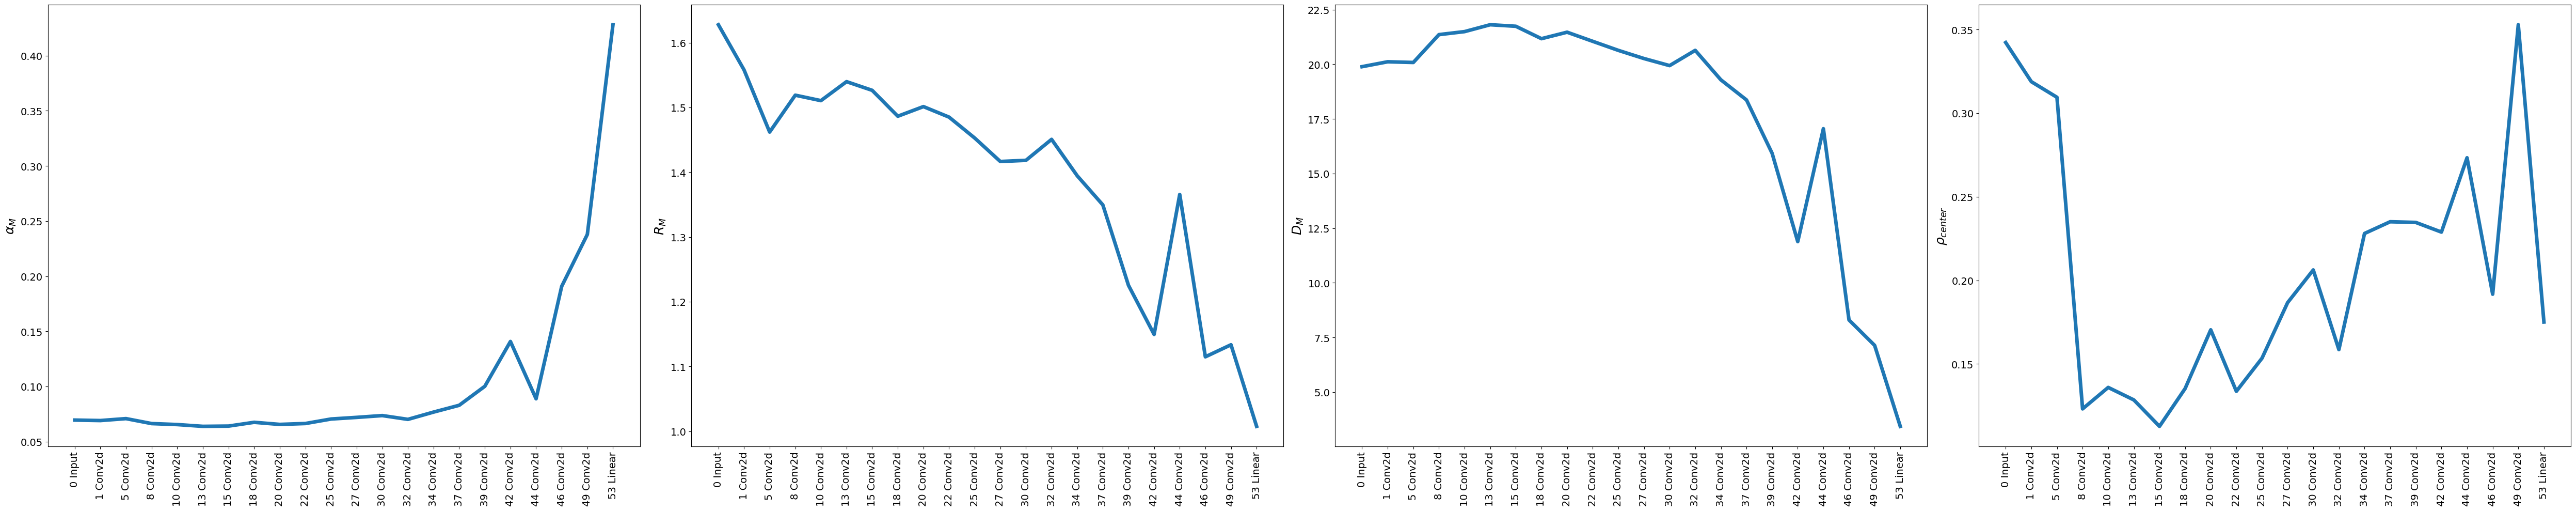

---------------------------------------------------------- 
For Gaussian Noise level: 0.1 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.1 : 29.09%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.071330, radius 1.545687, dimension 19.879834, correlation 0.316226
layer_1_Conv2d capacity: 0.075085, radius 1.450963, dimension 19.334056, correlation 0.296568
layer_5_Conv2d capacity: 0.069081, radius 1.

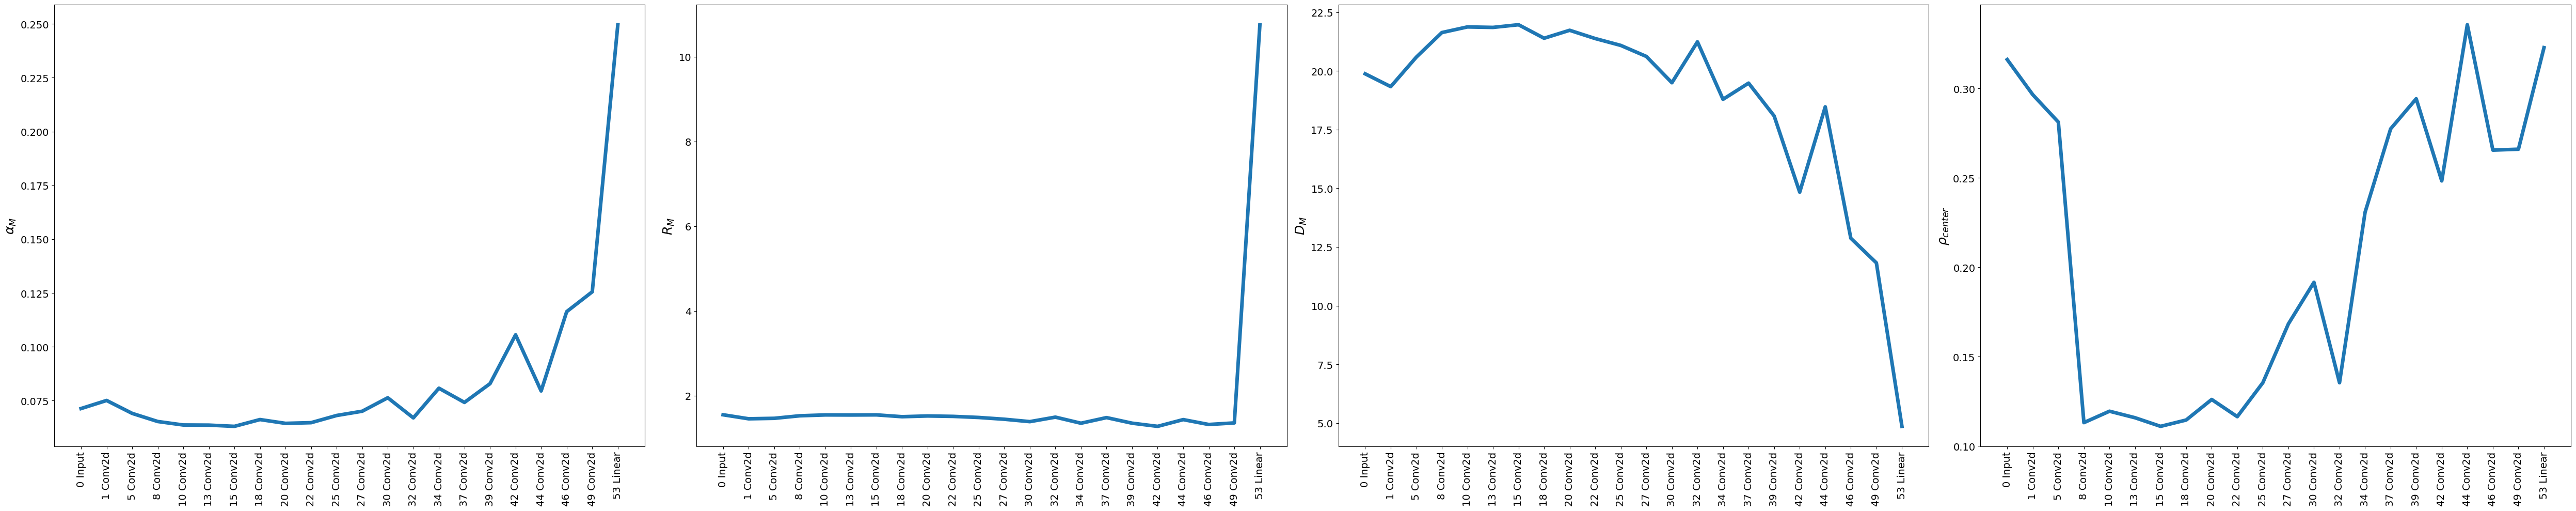

---------------------------------------------------------- 
For Gaussian Noise level: 0.25 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.25 : 12.34%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.071140, radius 1.472837, dimension 20.436054, correlation 0.263178
layer_1_Conv2d capacity: 0.068131, radius 1.484924, dimension 20.954503, correlation 0.234395
layer_5_Conv2d capacity: 0.064800, radius 

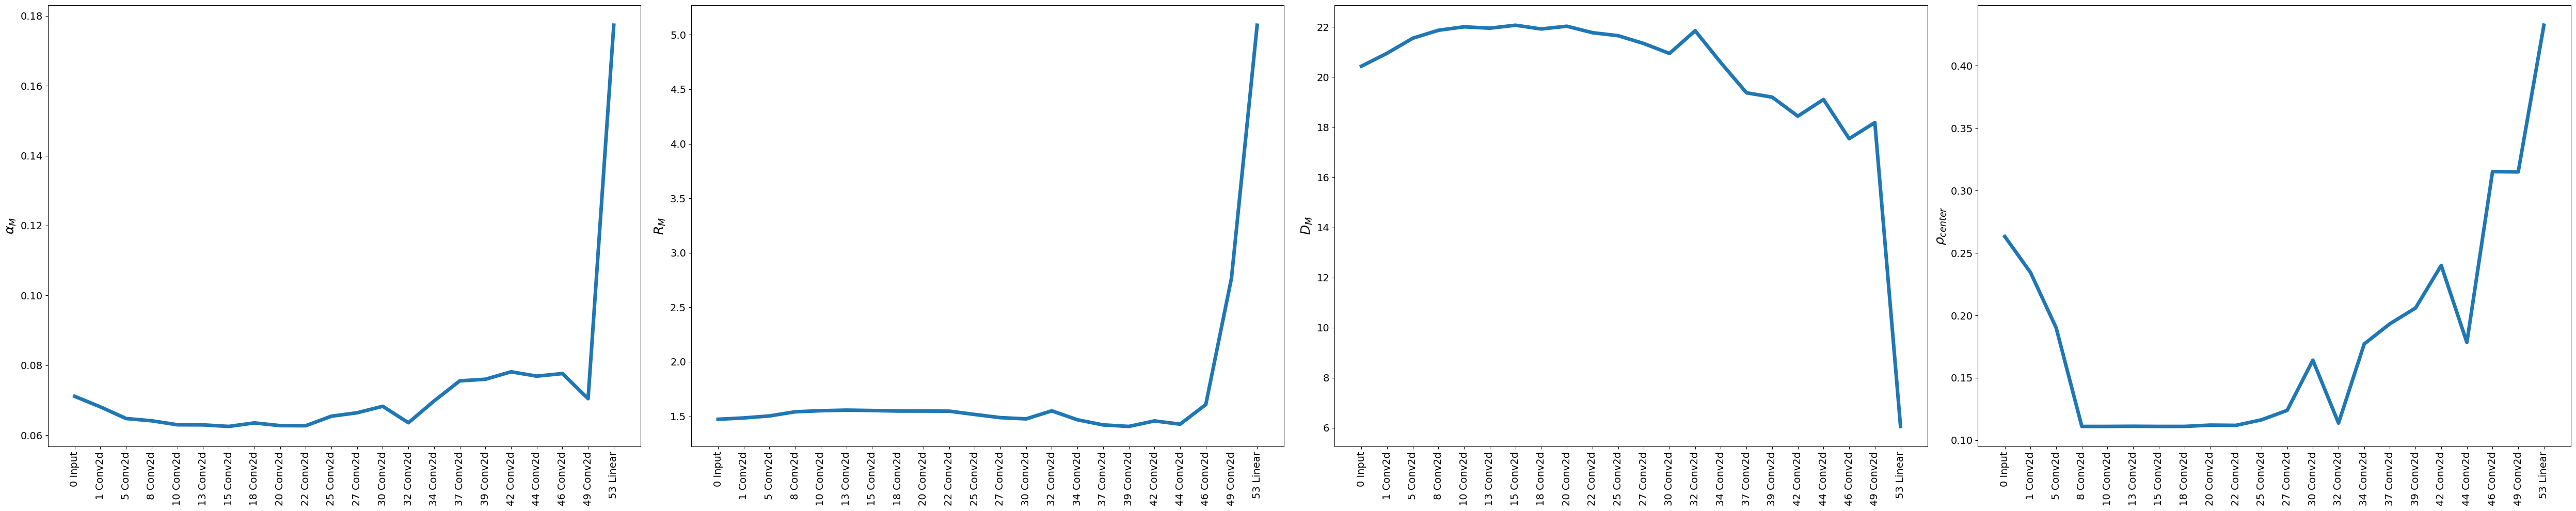

---------------------------------------------------------- 
For Gaussian Noise level: 0.5 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.5 : 9.99%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.064917, radius 1.541062, dimension 21.782542, correlation 0.164767
layer_1_Conv2d capacity: 0.064052, radius 1.533544, dimension 21.878226, correlation 0.144692
layer_5_Conv2d capacity: 0.062615, radius 1.5

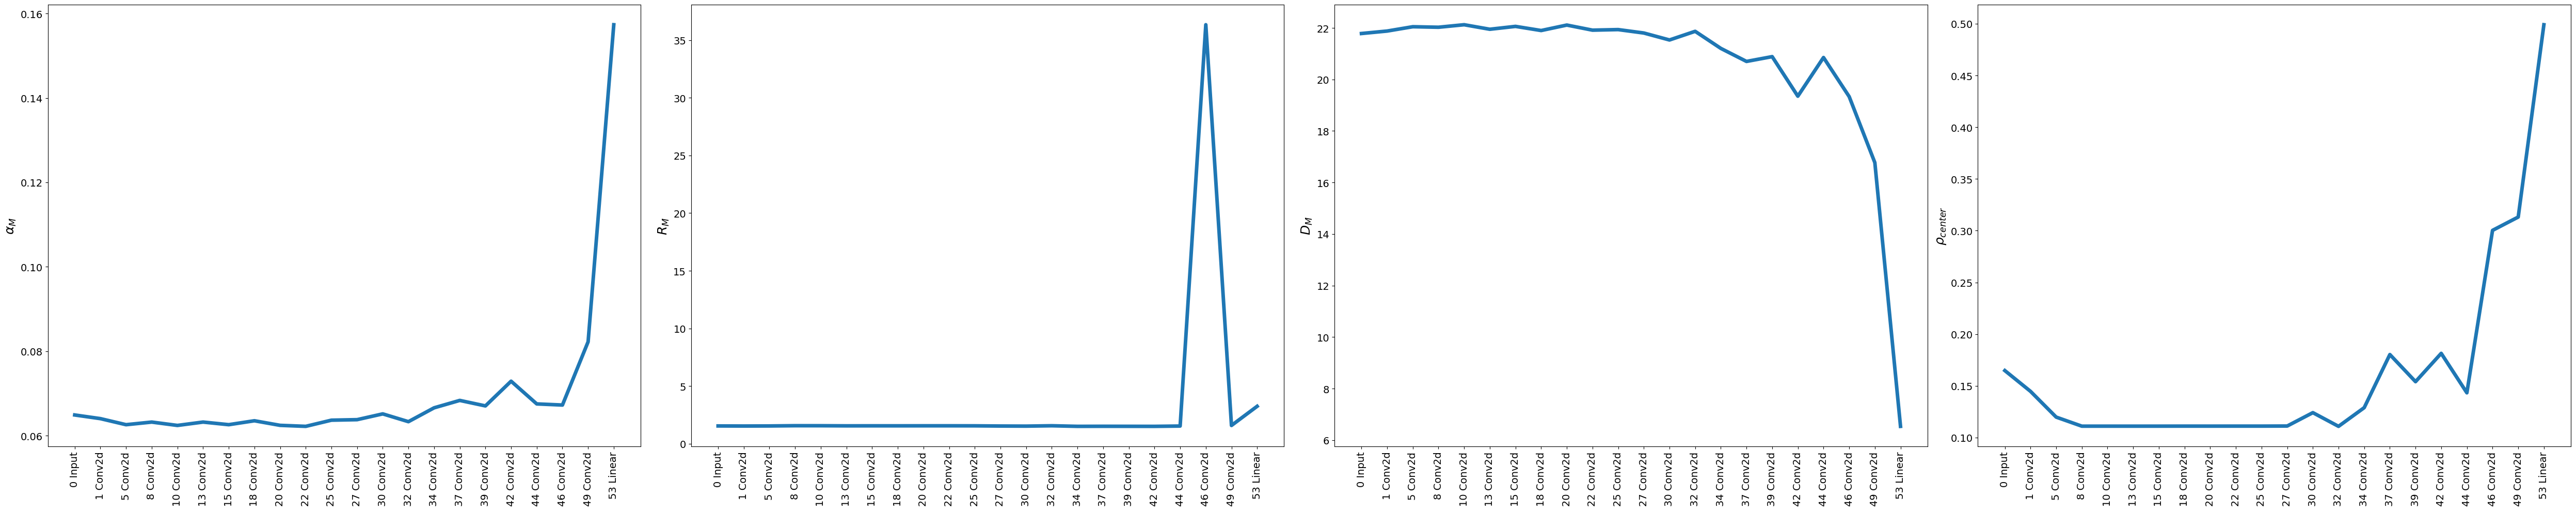

---------------------------------------------------------- 
For Gaussian Noise level: 0.75 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 0.75 : 10.03%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.064887, radius 1.535958, dimension 21.839100, correlation 0.123240
layer_1_Conv2d capacity: 0.063871, radius 1.534156, dimension 21.932807, correlation 0.115738
layer_5_Conv2d capacity: 0.062950, radius 

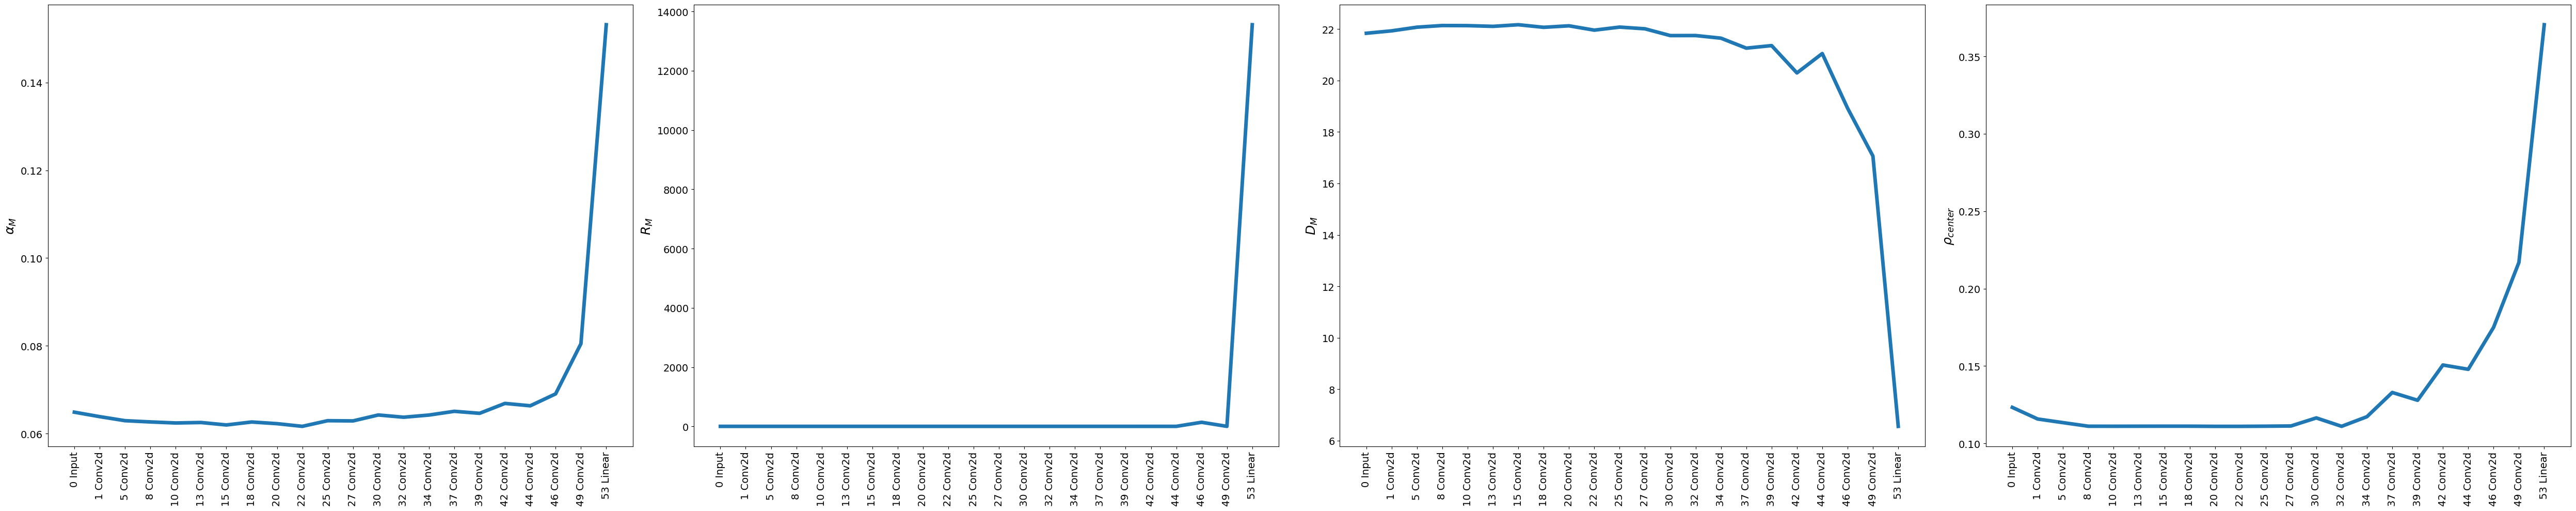

---------------------------------------------------------- 
For Gaussian Noise level: 1.0 
 ----------------------------------------------------------



Accuracy of the loaded model on a dataset with Gaussian Noise of 1.0 : 10.00%
Projecting layer_1_Conv2d
Projecting layer_5_Conv2d
Projecting layer_8_Conv2d
Projecting layer_10_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
Projecting layer_25_Conv2d
Projecting layer_27_Conv2d
Projecting layer_30_Conv2d
Projecting layer_32_Conv2d
Projecting layer_34_Conv2d
Projecting layer_37_Conv2d
Projecting layer_39_Conv2d
Projecting layer_42_Conv2d
Projecting layer_44_Conv2d
Projecting layer_46_Conv2d
Projecting layer_49_Conv2d
layer_0_Input capacity: 0.064003, radius 1.551662, dimension 22.007565, correlation 0.112766
layer_1_Conv2d capacity: 0.063534, radius 1.538376, dimension 22.005365, correlation 0.111096
layer_5_Conv2d capacity: 0.062352, radius 1.

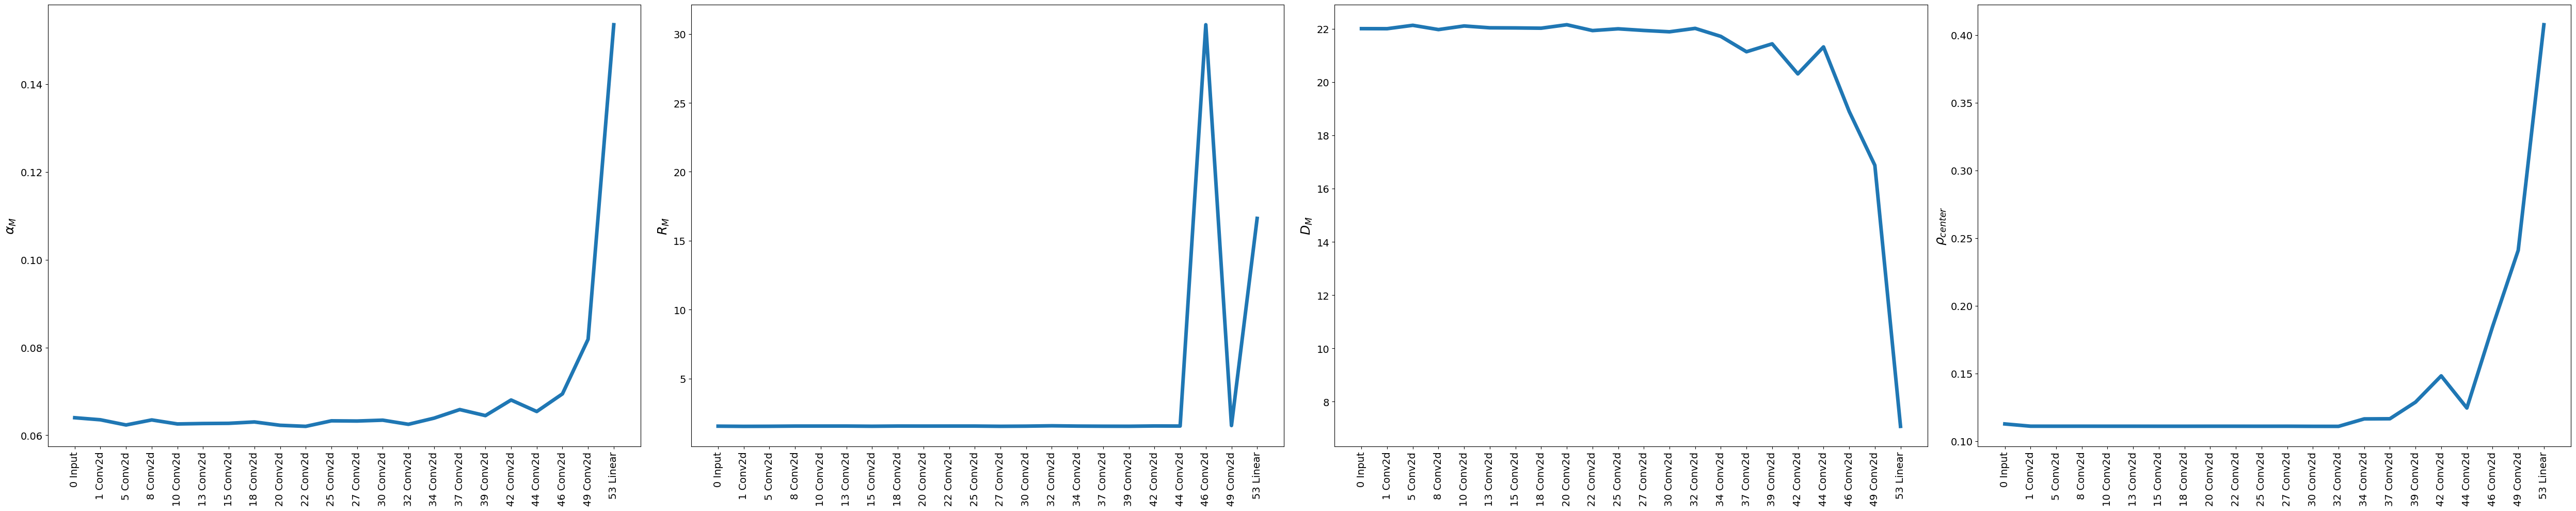

In [ ]:
test_accuaracies = [] # Testing accuracies for each data loaders
manifold_info = [] # MFTMA analysis results for corresponding data loader

for i, data_loader in enumerate(data_loaders):

  sd = gaussian_noises[i]

  print(f'----------------------------------------------------------'
      , f'\nFor Gaussian Noise level: {sd} \n',
        f'----------------------------------------------------------\n\n')

  # Check model accuracy
  test_loss, test_acc = model_evaluation(model, device, data_loader, epoch=1)
  test_accuaracies.append(test_acc)
  print(f'\nAccuracy of the loaded model on a dataset with Gaussian Noise of {sd} : {test_acc:.2f}%')

  # ============ MFTMA ==========================

  # Prepare Manifold data
  sampled_classes = 10
  examples_per_class = 30
  data = make_manifold_data(gn_datasets[i], sampled_classes, examples_per_class, seed=0)
  data = [d.to(device) for d in data]

  # Extract activations from the model
  activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
  list(activations.keys())

  # Prepare activations for analysis
  for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

  # Run the analysis on the prepped activations
  capacities = []
  radii = []
  dimensions = []
  correlations = []

  for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)

    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))

    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)

  # Plot the results
  fig, axes = plt.subplots(1, 4, figsize=(50, 10))
  axes[0].plot(capacities, linewidth=5)
  axes[1].plot(radii, linewidth=5)
  axes[2].plot(dimensions, linewidth=5)
  axes[3].plot(correlations, linewidth=5)

  axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
  axes[1].set_ylabel(r'$R_M$', fontsize=18)
  axes[2].set_ylabel(r'$D_M$', fontsize=18)
  axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

  names = list(activations.keys())
  names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
  for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

  plt.tight_layout()
  plt.show()

  manifold_info.append([capacities, radii, dimensions, correlations])

### Summary

---------------------------------------------------------- 
For Gaussian Noise level: 0 
 ----------------------------------------------------------


Model accuracy: 94.03


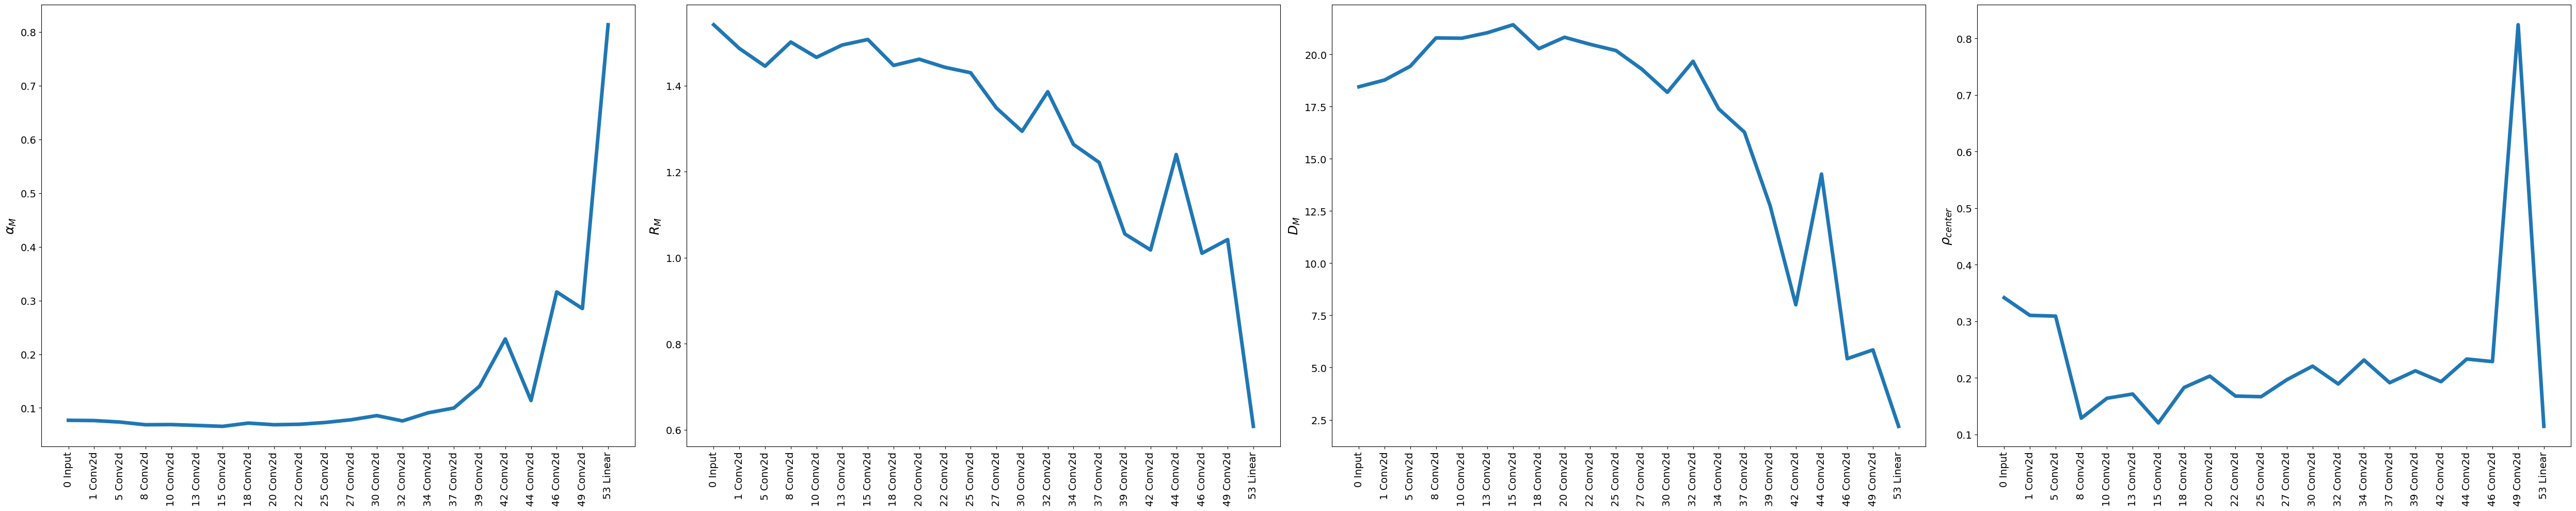

---------------------------------------------------------- 
For Gaussian Noise level: 0.0001 
 ----------------------------------------------------------


Model accuracy: 93.68


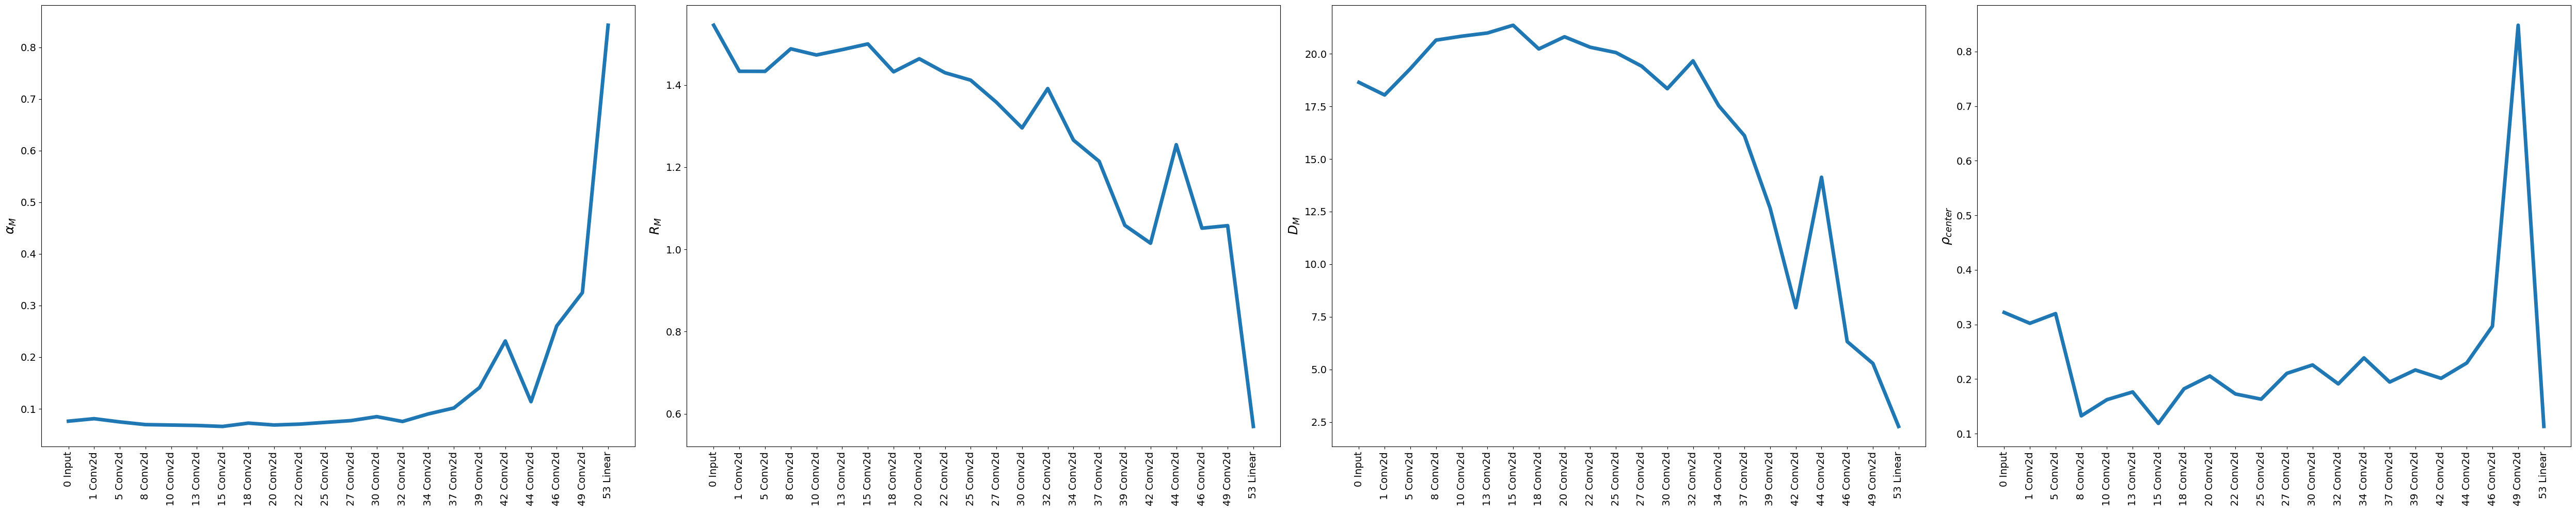

---------------------------------------------------------- 
For Gaussian Noise level: 0.0005 
 ----------------------------------------------------------


Model accuracy: 93.86


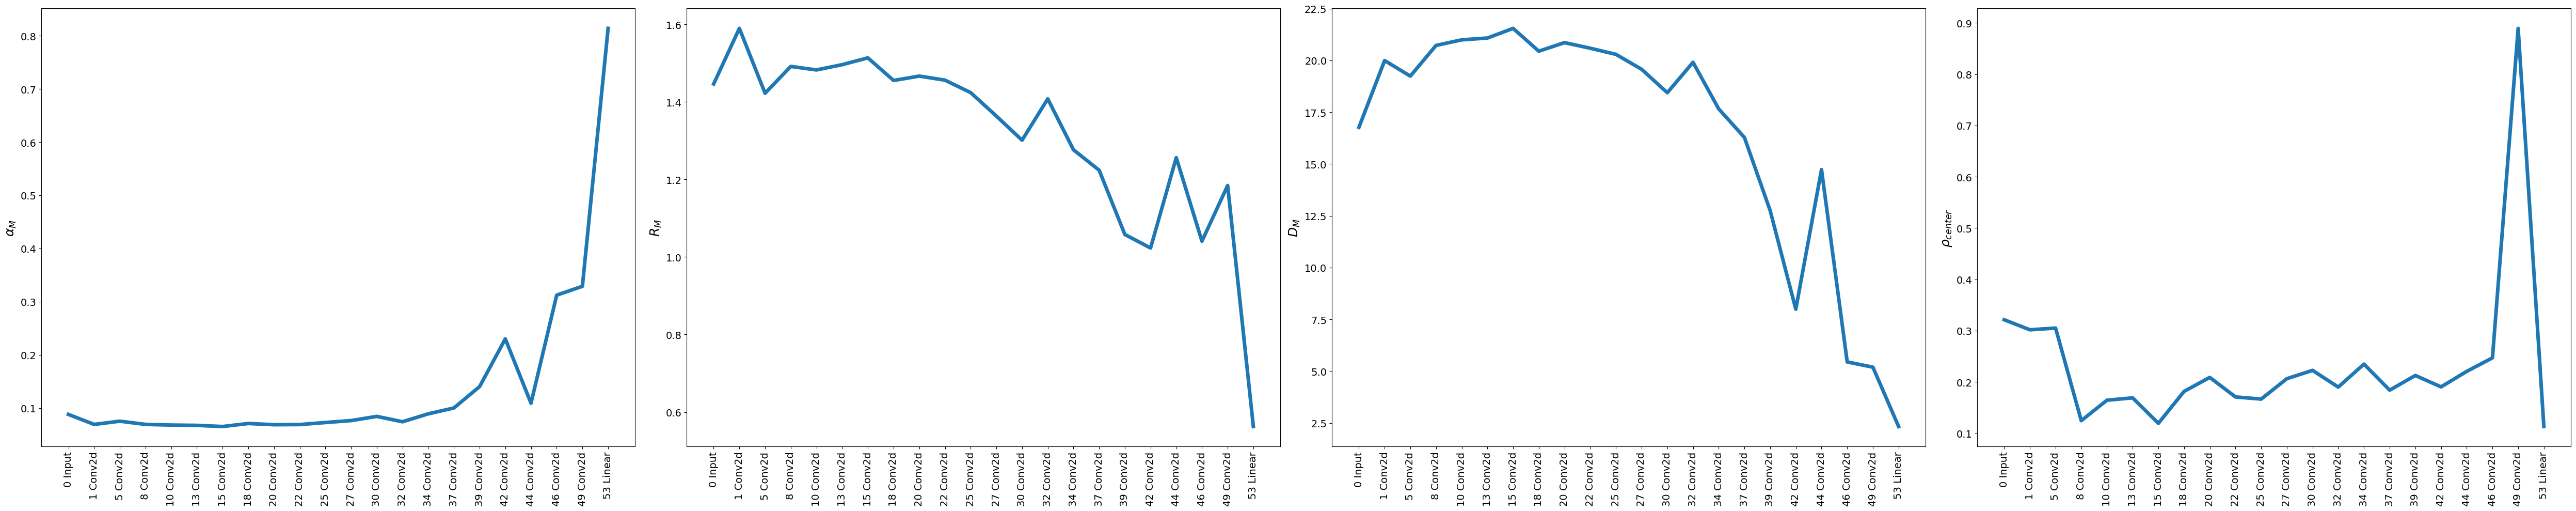

---------------------------------------------------------- 
For Gaussian Noise level: 0.001 
 ----------------------------------------------------------


Model accuracy: 93.85


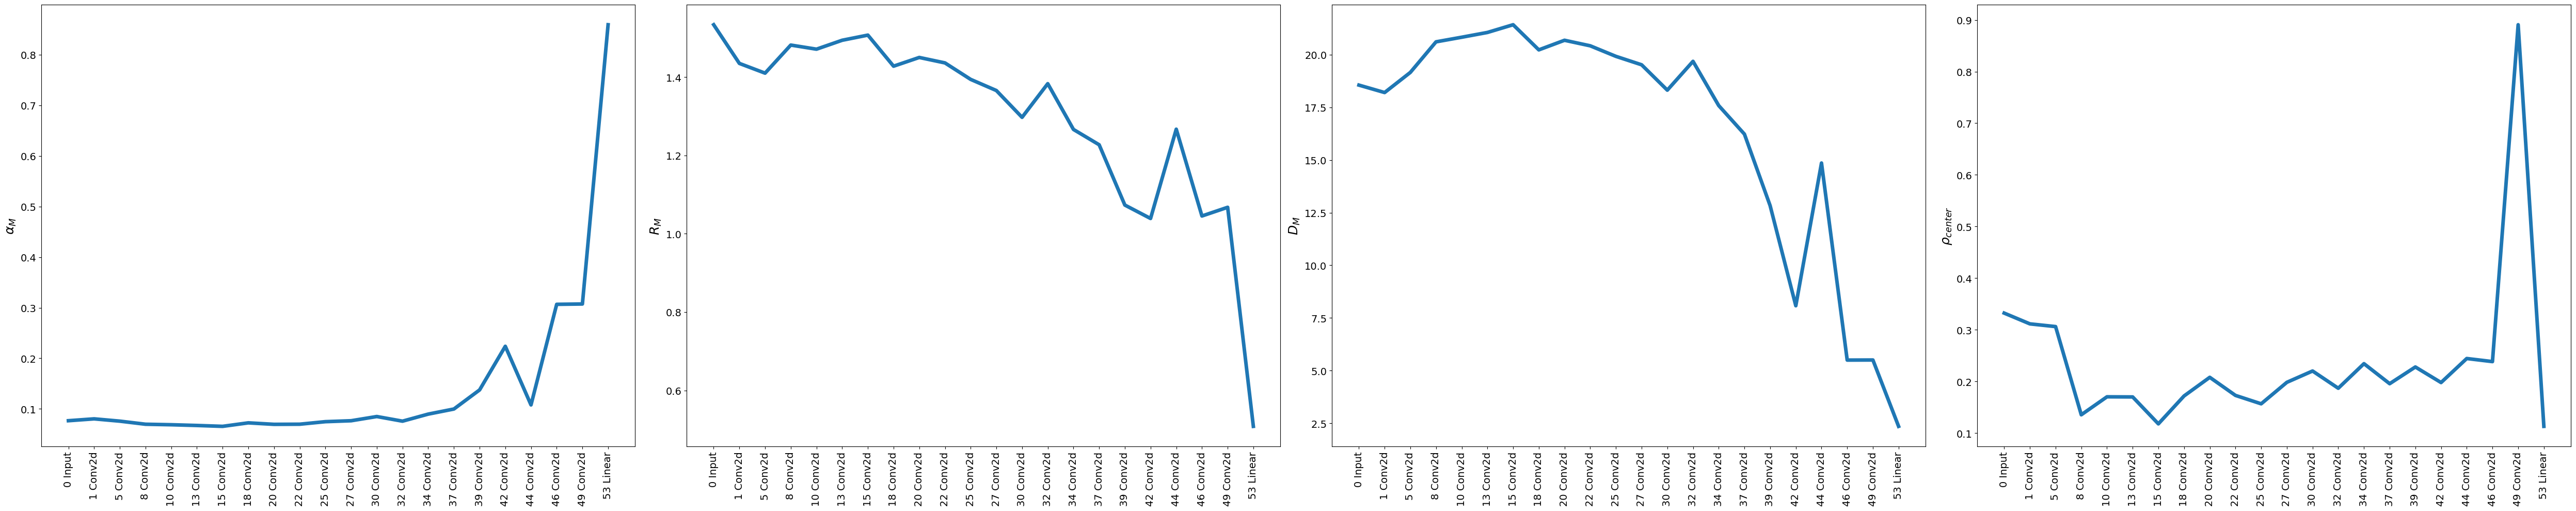

---------------------------------------------------------- 
For Gaussian Noise level: 0.005 
 ----------------------------------------------------------


Model accuracy: 93.66


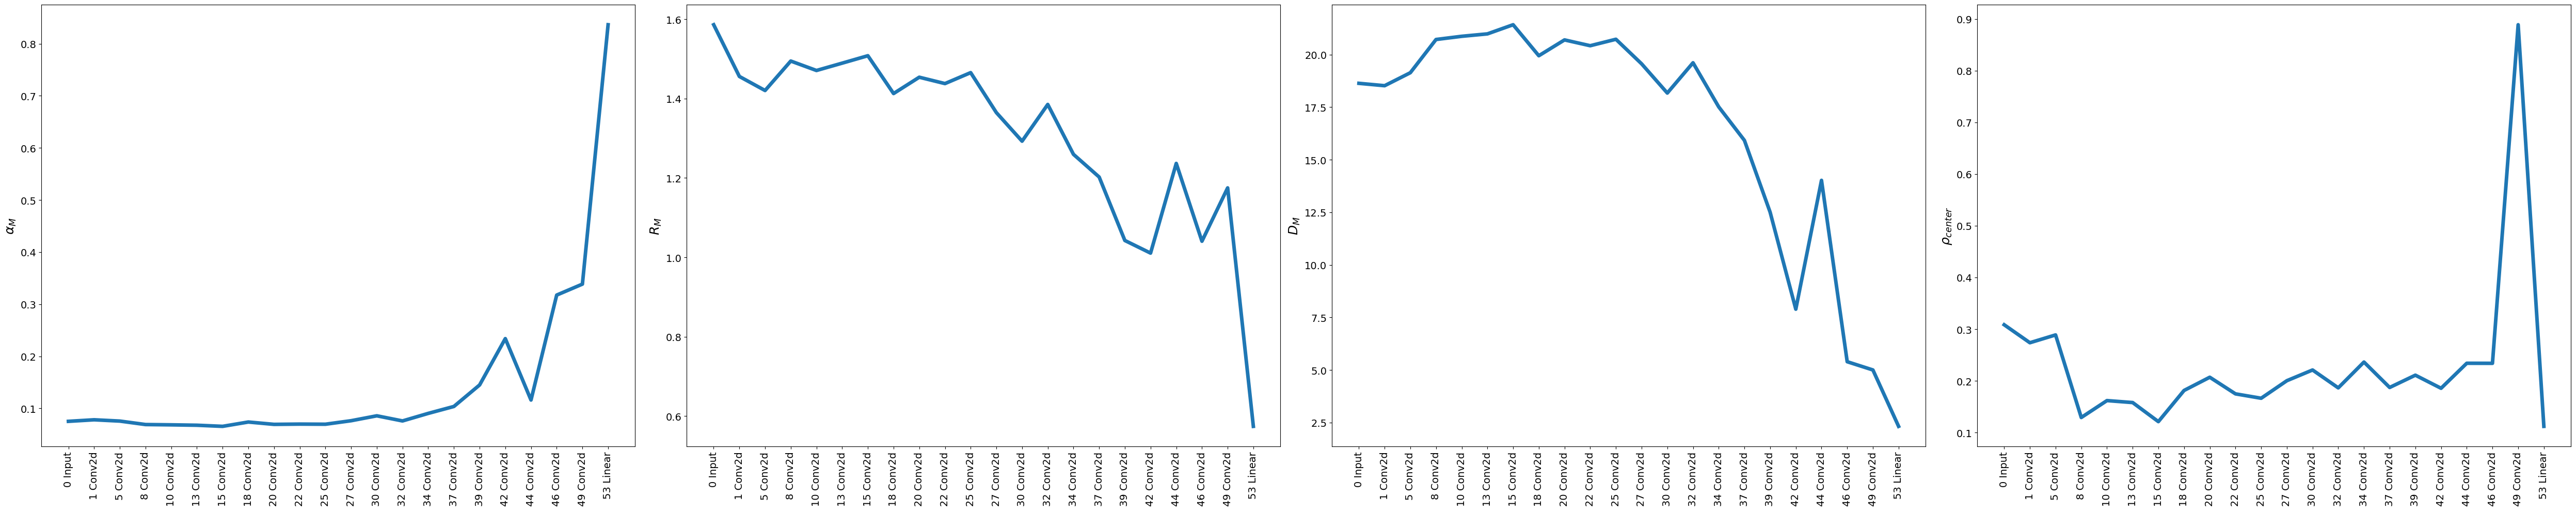

---------------------------------------------------------- 
For Gaussian Noise level: 0.01 
 ----------------------------------------------------------


Model accuracy: 93.62


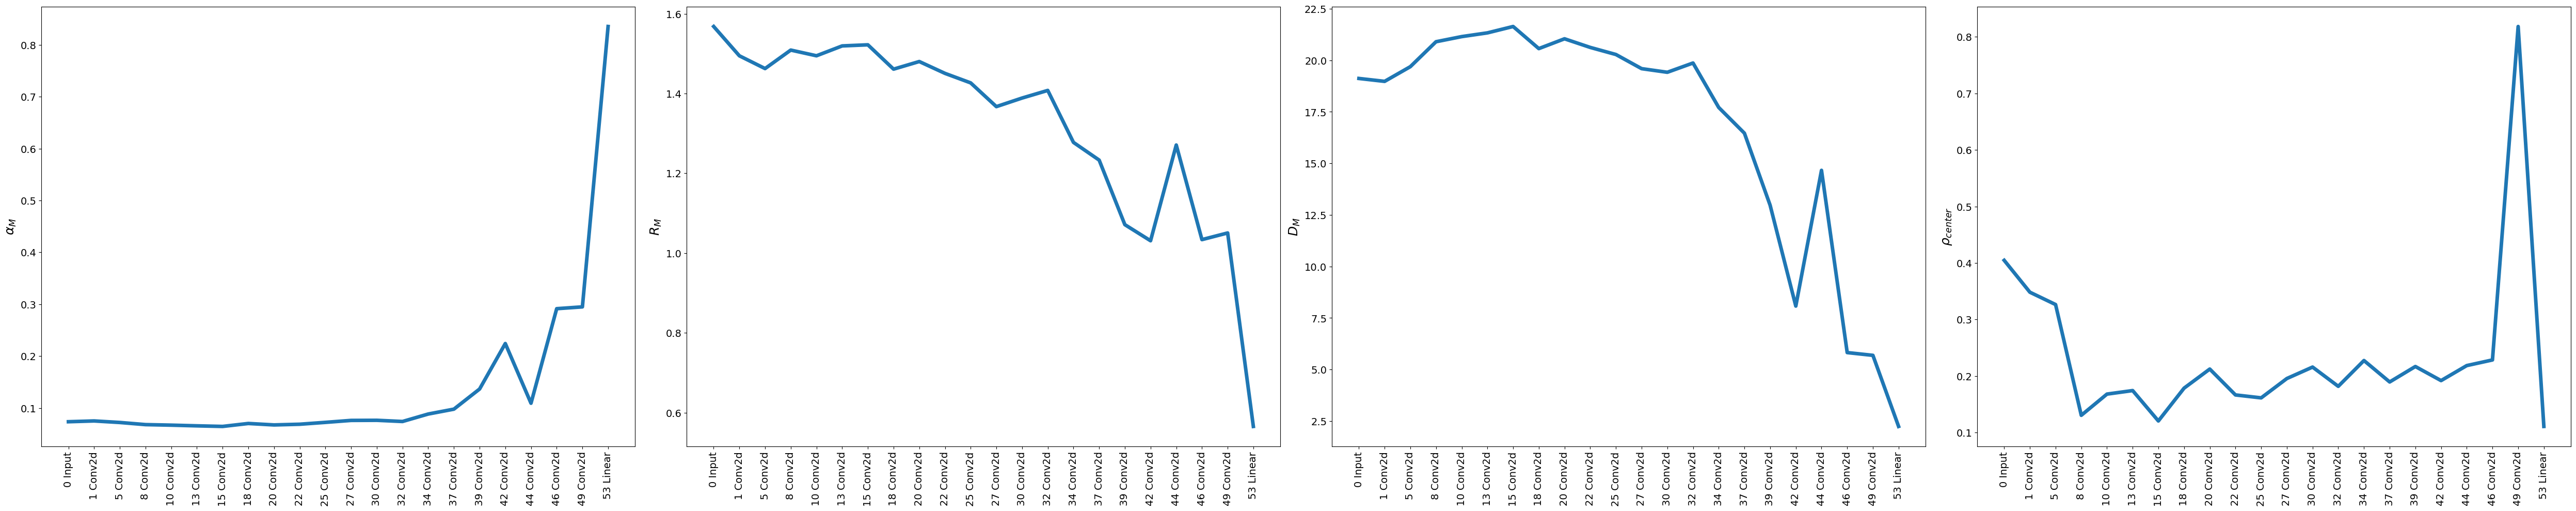

---------------------------------------------------------- 
For Gaussian Noise level: 0.05 
 ----------------------------------------------------------


Model accuracy: 69.77


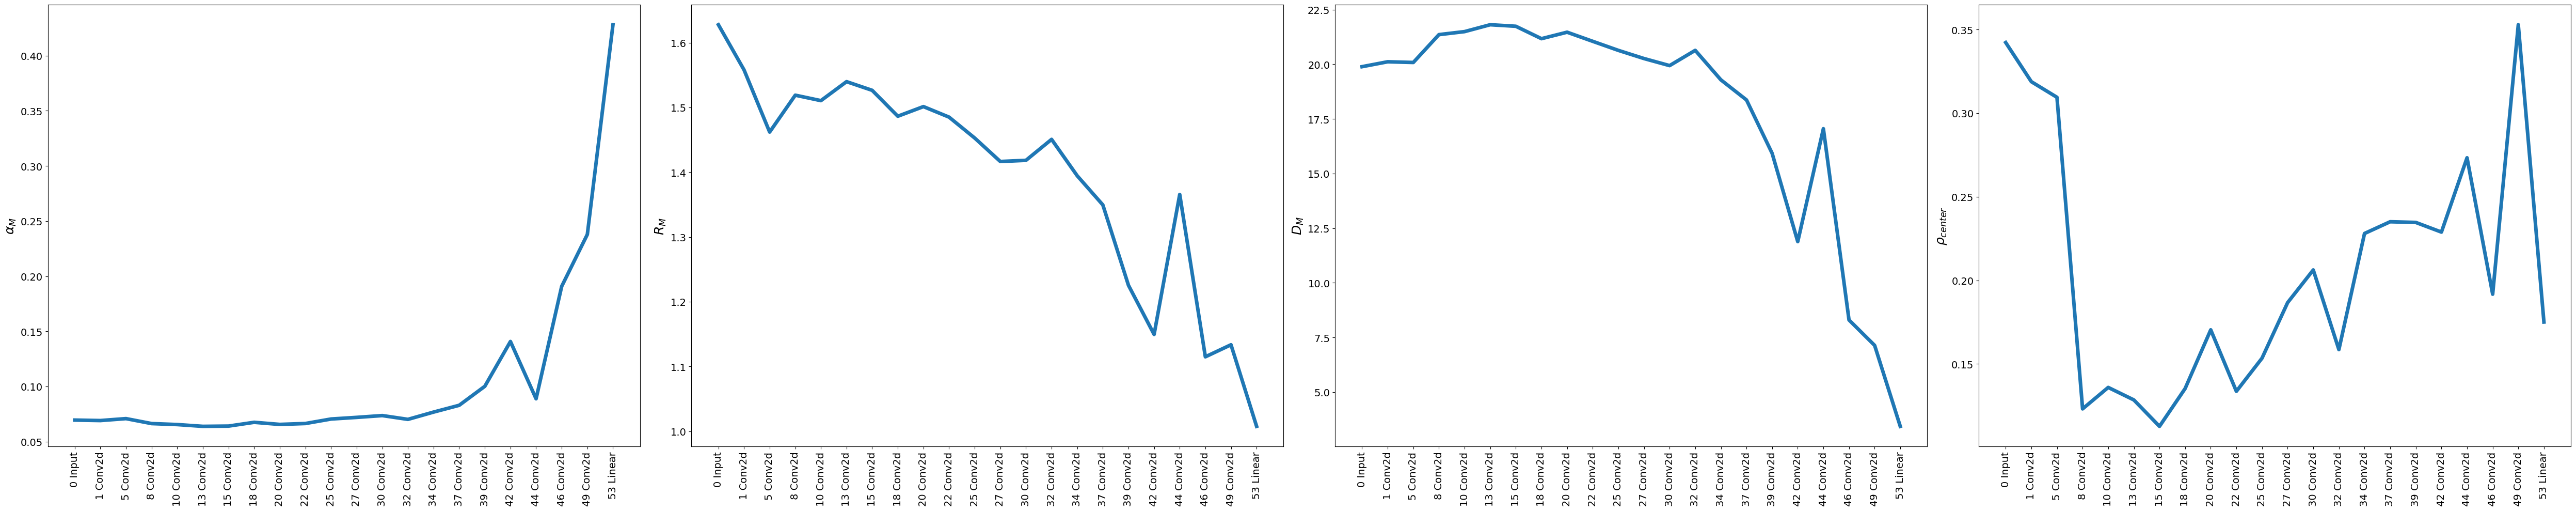

---------------------------------------------------------- 
For Gaussian Noise level: 0.1 
 ----------------------------------------------------------


Model accuracy: 29.09


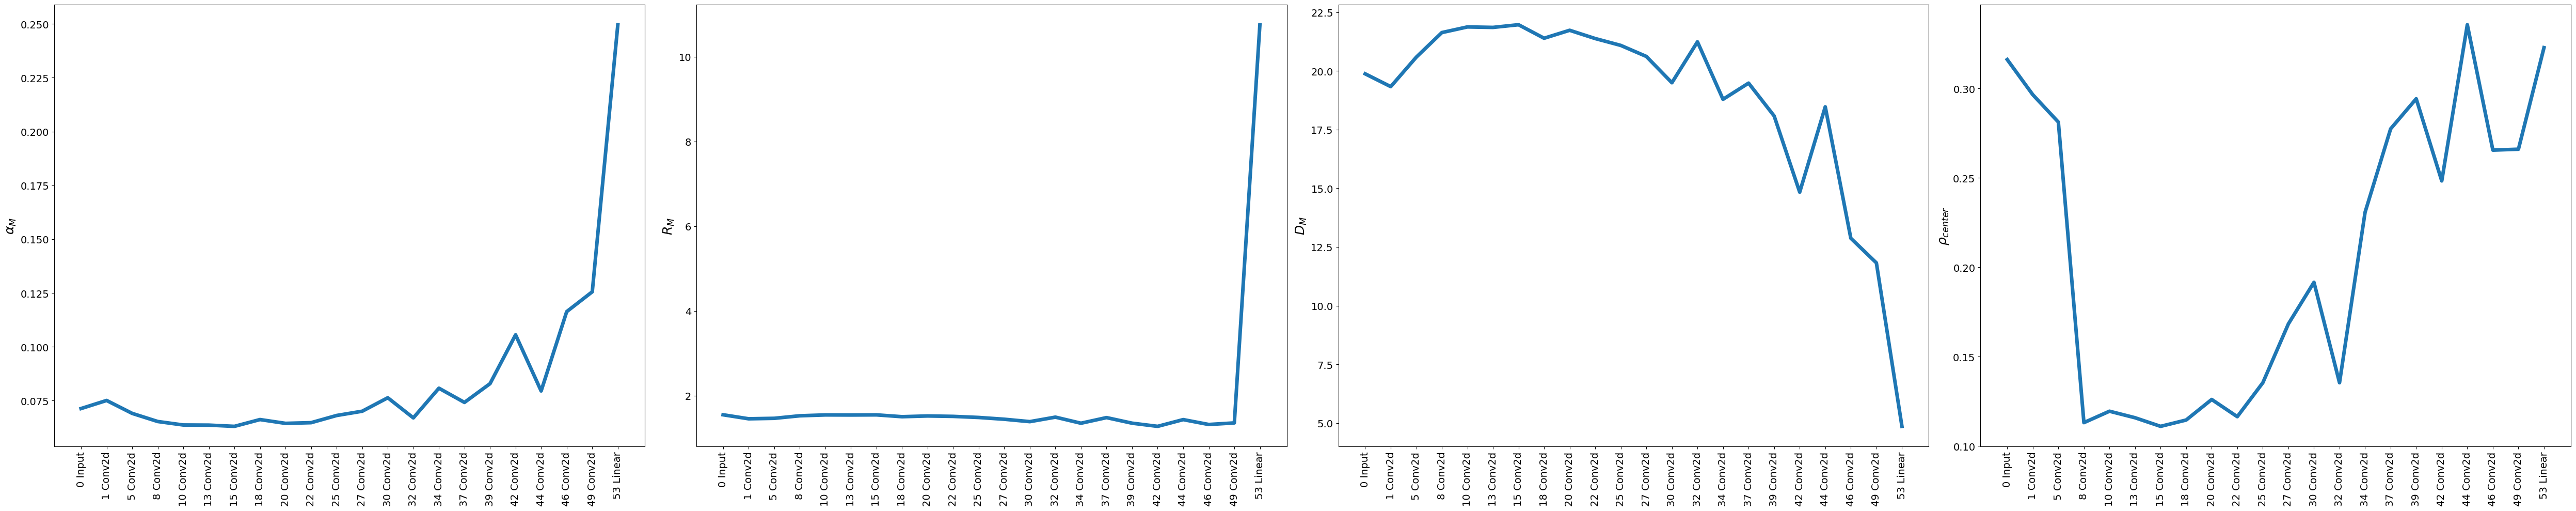

---------------------------------------------------------- 
For Gaussian Noise level: 0.25 
 ----------------------------------------------------------


Model accuracy: 12.34


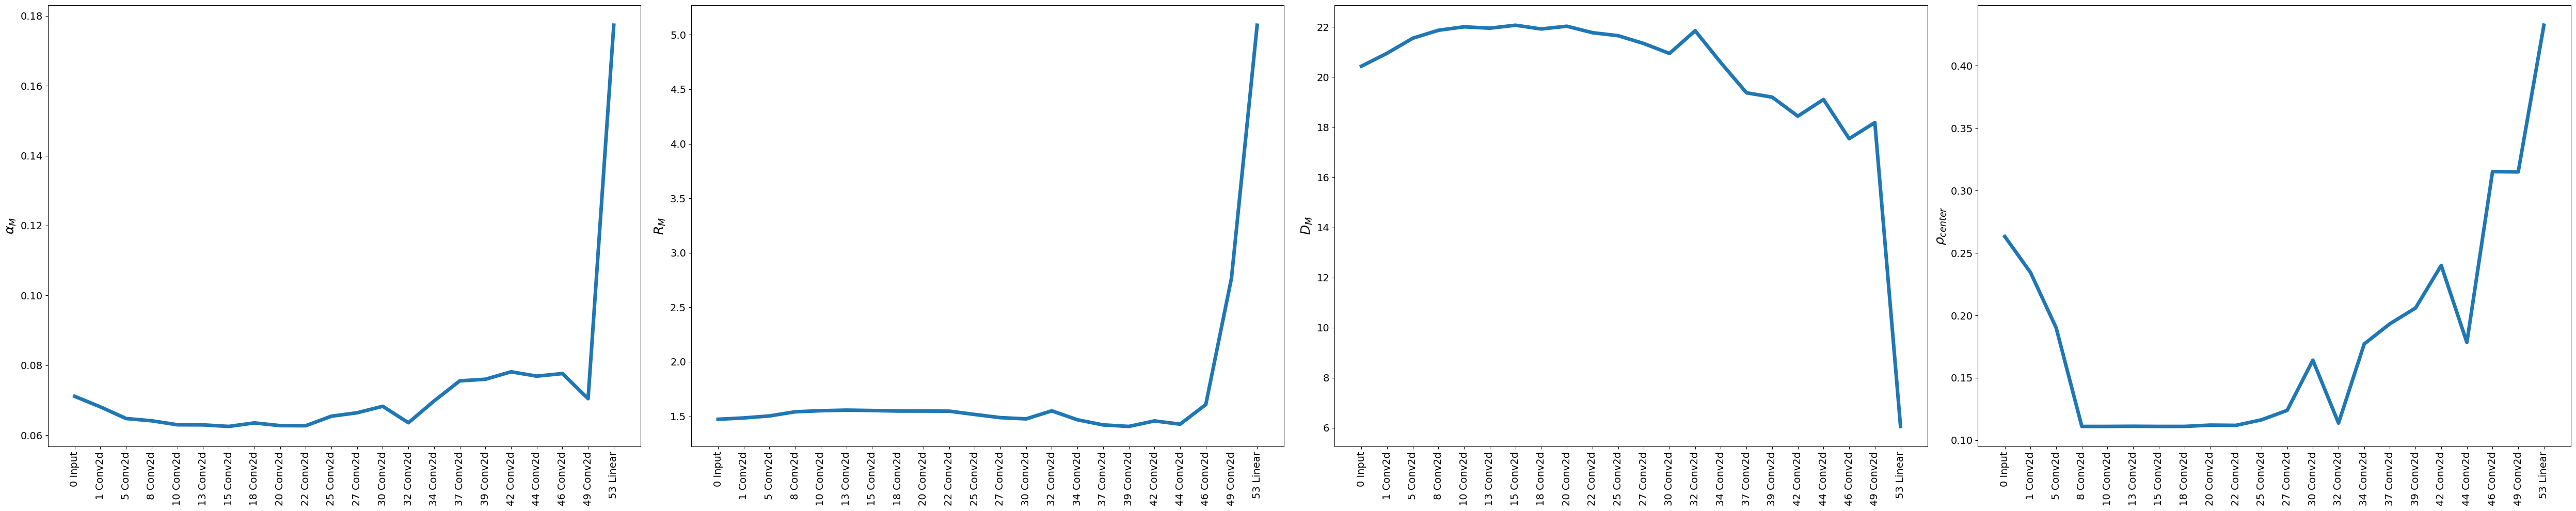

---------------------------------------------------------- 
For Gaussian Noise level: 0.5 
 ----------------------------------------------------------


Model accuracy: 9.99


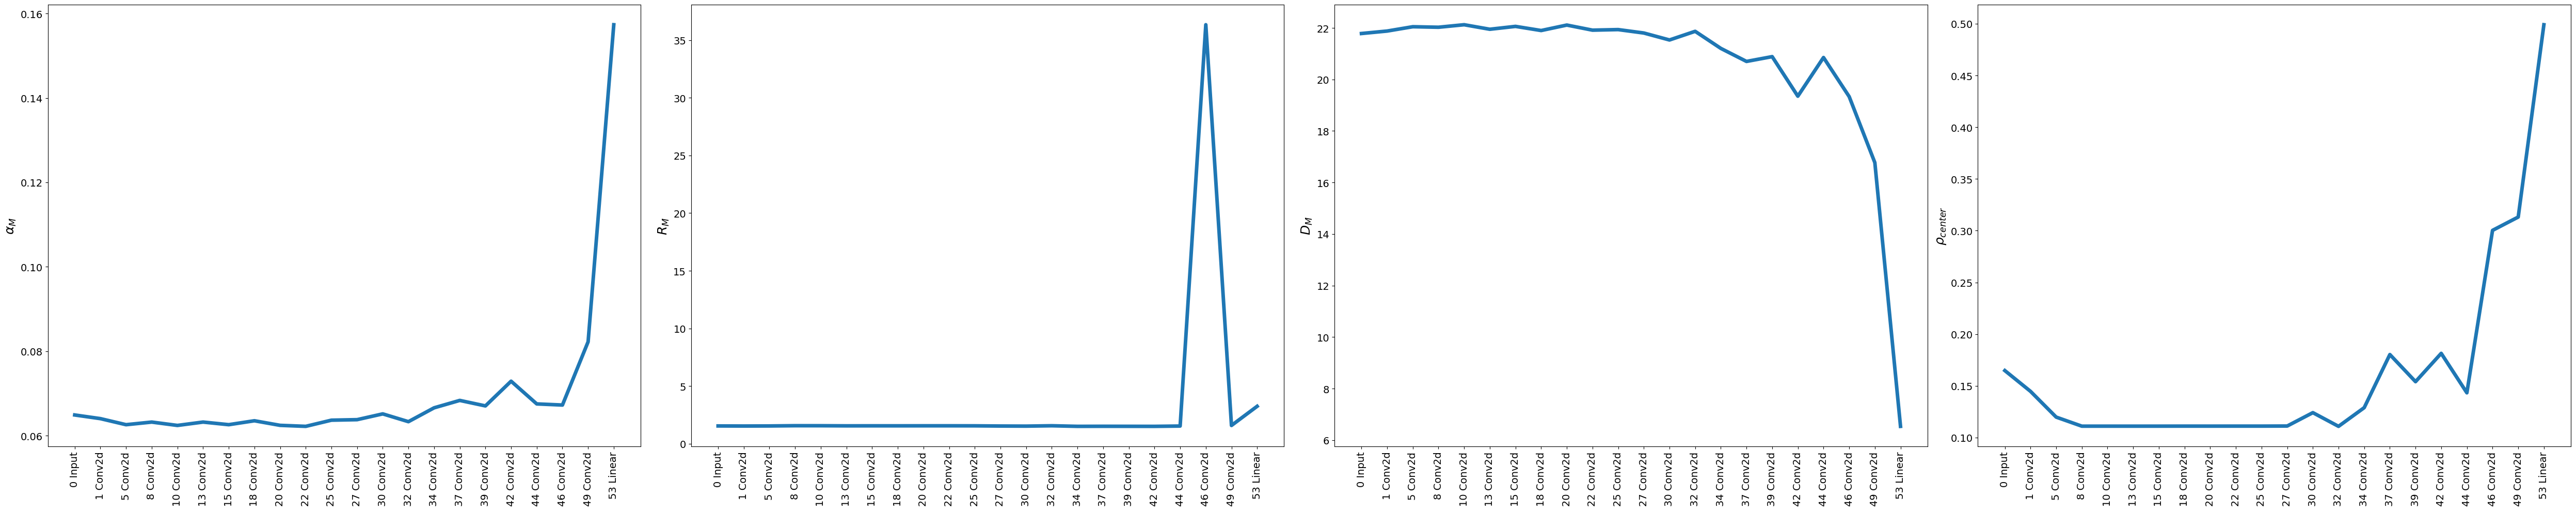

---------------------------------------------------------- 
For Gaussian Noise level: 0.75 
 ----------------------------------------------------------


Model accuracy: 10.03


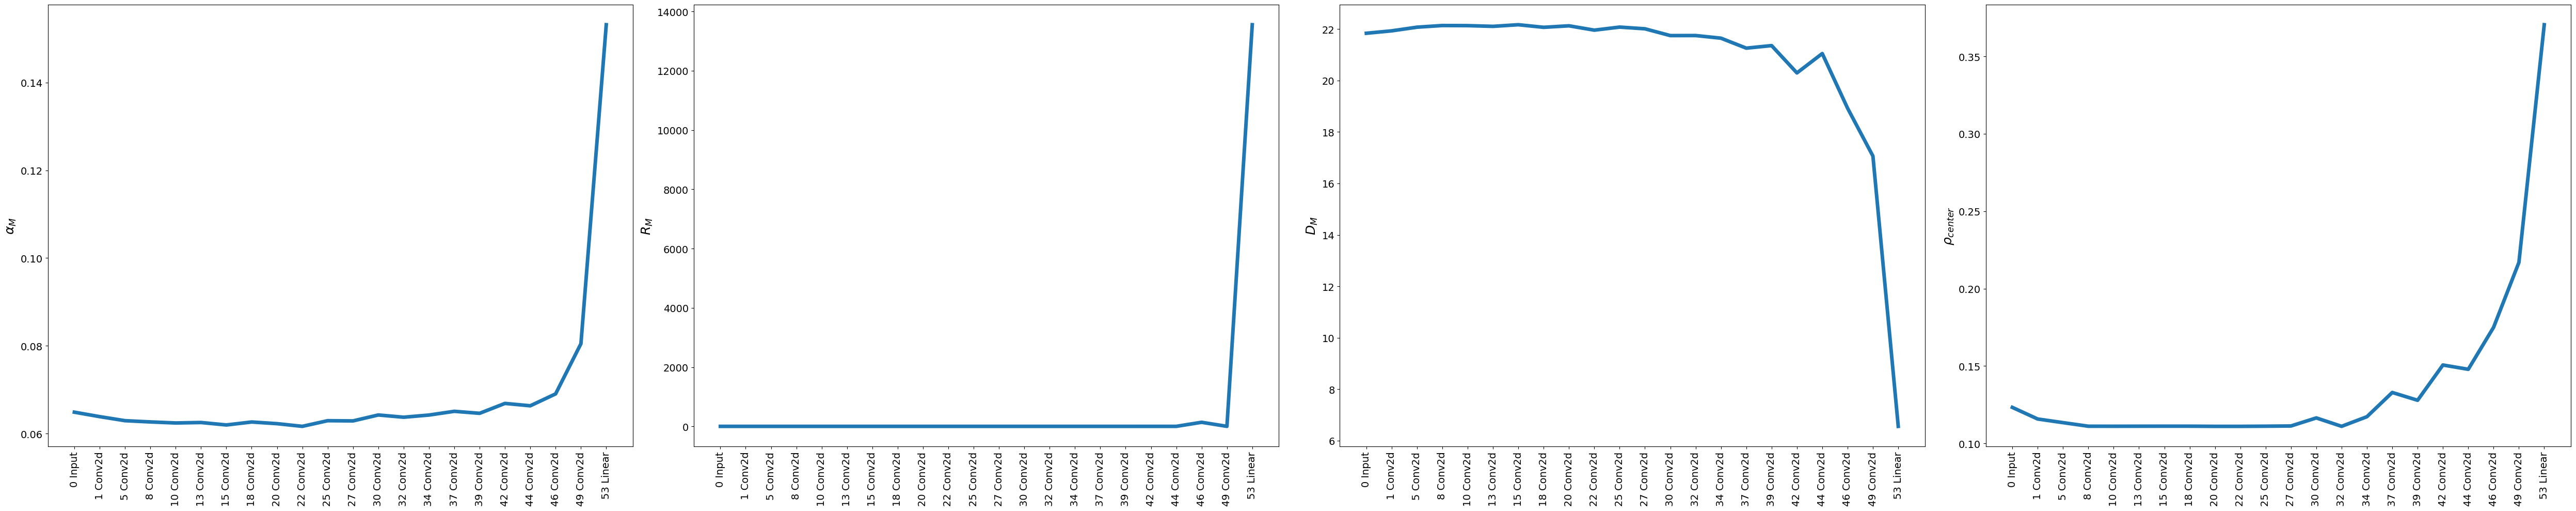

---------------------------------------------------------- 
For Gaussian Noise level: 1.0 
 ----------------------------------------------------------


Model accuracy: 10.0


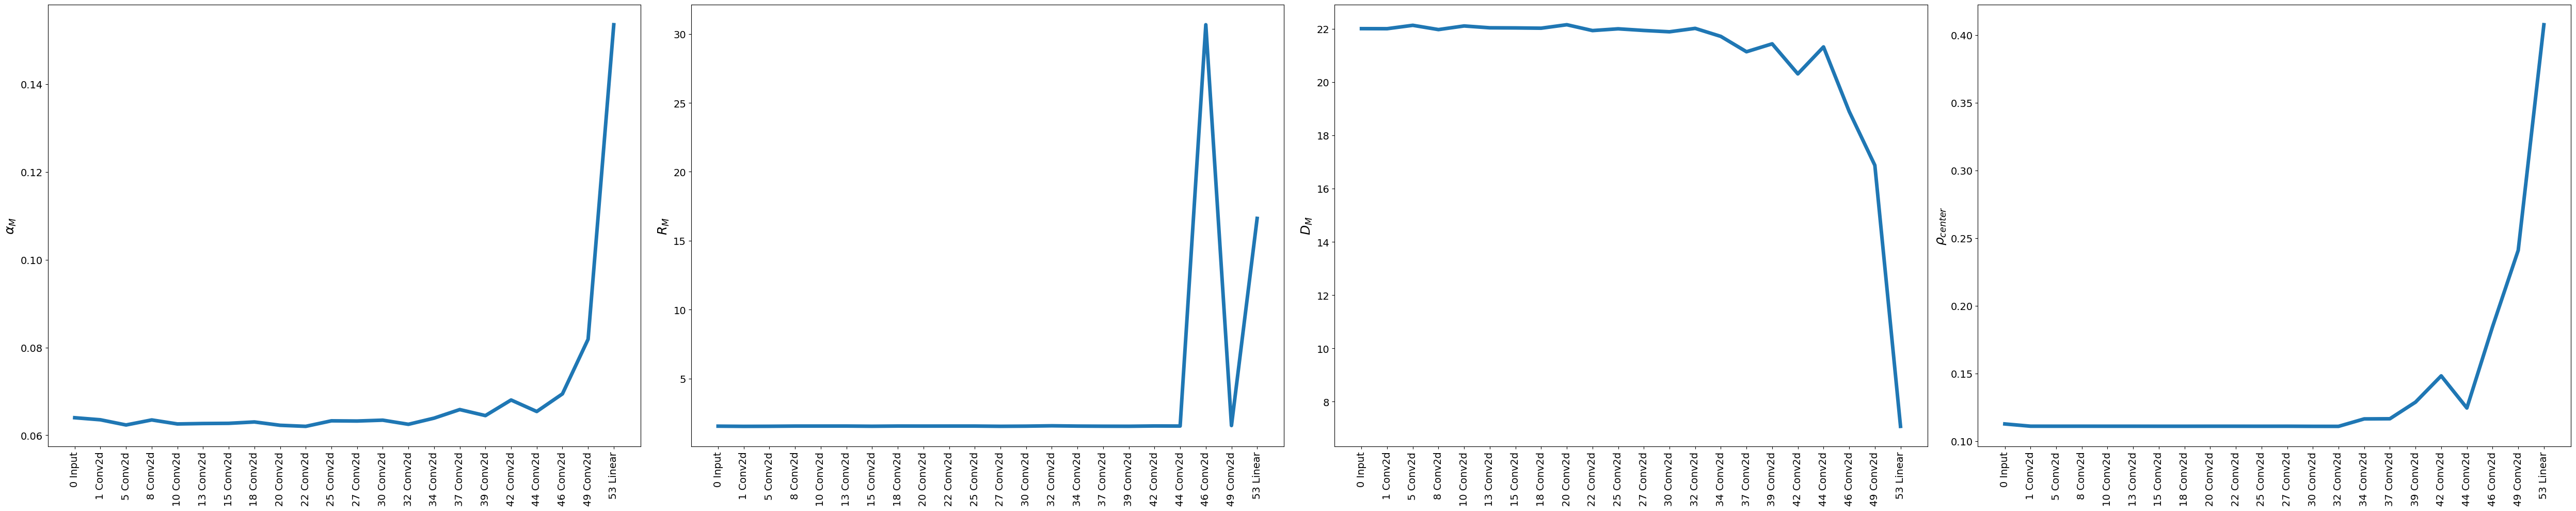

In [ ]:
# Plot details of Model accuracies and manifold analysis results

for i, gn in enumerate(gaussian_noises):
  print(f'----------------------------------------------------------'
      , f'\nFor Gaussian Noise level: {gn} \n',
        f'----------------------------------------------------------\n\n')
  print(f'Model accuracy: {test_accuaracies[i]}')
  capacities = manifold_info[i][0]
  radii = manifold_info[i][1]
  dimensions = manifold_info[i][2]
  correlations = manifold_info[i][3]

  # Plot the results
  fig, axes = plt.subplots(1, 4, figsize=(50, 10))
  axes[0].plot(capacities, linewidth=5)
  axes[1].plot(radii, linewidth=5)
  axes[2].plot(dimensions, linewidth=5)
  axes[3].plot(correlations, linewidth=5)

  axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
  axes[1].set_ylabel(r'$R_M$', fontsize=18)
  axes[2].set_ylabel(r'$D_M$', fontsize=18)
  axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

  names = list(activations.keys())
  names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
  for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

  plt.tight_layout()
  plt.show()

